In [ ]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 39.7 MB/s eta 0:00:00


In [1]:
import random  # Import required module
import matplotlib.pyplot as plt  # Import required module
import math  # Import required module

In [ ]:
class View:
    def __init__(self, index: float, quality: float):
        self.index = index
        self.quality = quality
    def __call__(self):
        print("View",self.index, "Quality:", self.quality)  # Print output to console
class Viewer:
    def __init__(self, id: int, x: int, y: int, requested_index: float = None, min_quality: float = None, min_datarate: float = None, bid: float = 0, cached_views = None, channel_states = None, grid: int= 0):
        self.x = x
        self.y = y
        self.id = id
        self.requested_index = requested_index
        self.min_quality = min_quality
        self.min_datarate = min_datarate
        self.bid = bid
        self.cached_views = [] if cached_views is None else cached_views
        self.channel_states = channel_states
        if x>=0:
          self.grid = 1 if y>=0 else 4
        else:
          self.grid = 2 if y>=0 else 3

    def __call__(self):
        print("Viewer", self.id, "Grid", self.grid, "Request:", self.requested_index, "min_Q:", self.min_quality, "min_R:", self.min_datarate, "bid:", self.bid)  # Print output to console
        print("Cache:")  # Print output to console
        for i in self.cached_views:
          i()
class Transmitter:
    def __init__(self, id: int, x: int, y: int, cached_views=None):
        self.id = id
        self.x = x
        self.y = y
        self.cached_views = [] if cached_views is None else cached_views

    def __call__(self):
        print(f"Transmitter at ({self.x}, {self.y})")  # Print output to console

class D2D_Transmitter(Transmitter):
    def __init__(self, id: int, x: int, y: int, cached_views=None, grid = 0):
        super().__init__(id, x, y, cached_views)
        if x>=0:
          self.grid = 1 if y>=0 else 4
        else:
          self.grid = 2 if y>=0 else 3

    def __call__(self):
        print(f"D2D Transmitter {self.id} in grid {self.grid}")  # Print output to console
        print("Cache:")  # Print output to console
        for i in self.cached_views:
          i()

class BS(Transmitter):
    def __init__(self, id: int, x: int, y: int, BS_capacity: int, cached_views=None):
        super().__init__(id, x, y, cached_views)
        self.BS_capacity = BS_capacity

    def __call__(self):
        print(f"BS with capacity {self.BS_capacity} at ({self.x}, {self.y})")  # Print output to console
class Delivery:
    def __init__(self, viewer: Viewer, delivery_mode: str, transmitters: list, cost: float):
        self.viewer = viewer
        self.delivery_mode = delivery_mode
        self.transmitters = transmitters  # This should be a list of Transmitter instances
        self.cost = cost
        self.utility = viewer.bid - cost

    def __call__(self):
        print("View", self.viewer.requested_index,"for Viewer",self.viewer.id, "Mode:", self.delivery_mode, "Transmitters:",end=" ")  # Print output to console
        for t in self.transmitters:
          if type(t) == BS:
            print("BS",end=" ")  # Print output to console
          else:
            print("D2D#", t.id,end=" ")  # Print output to console
        print("Utility:", self.utility)  # Print output to console

In [ ]:
def randomCacheD2D(size: int, qualities: float, view_index_set):
  cache = []
  for i in range(size):
    cache.append(View(index = random.choice(view_index_set), quality = random.choice(qualities)))
  return cache

def randomCacheViewer(size: int, qualities: float, view_index_set):
  i = random.uniform(0,1)
  if i < 0.5: return []
  cache = []
  for i in range(size):
    cache.append(View(index = random.choice(view_index_set), quality = random.choice(qualities)))
  return cache

def randomChannelStates(size : int):
  #cs = [random.uniform(0.5, 1)]
  cs = [random.uniform(0.01, 0.1)]
  for i in range(size):
    cs.append(random.uniform(0.01, 0.1))
    #cs.append(1.5e-6)
  return cs

def initiateViewer(start: int, V: int, W: int, num_viewers: int, num_d2d: int, grid_size: int):

    i = 1
    view_index_set = []
    while i <= V:
      view_index_set.append(i)
      i+=(1/W)

    integer_views = [View(i, 1) for i in range(1, V+1)]
    request_qualities = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    cache_qualities = [0.6, 0.8, 1]
    viewer_cache = 1
    viewers = [
        Viewer(id=start+i+1, x=random.randint(-grid_size, grid_size), y=random.randint(-grid_size, grid_size),
               requested_index = random.choice(view_index_set), min_quality = random.choice(request_qualities),
               min_datarate = random.uniform(0,1), bid = random.uniform(1,10), cached_views = randomCacheViewer(viewer_cache ,cache_qualities, view_index_set),
               channel_states = randomChannelStates(num_d2d)) for i in range(num_viewers)
      ]
    return viewers

def initiateD2D(start: int, V: int, W: int, num_d2d: int, grid_size: int):
    i = 1
    view_index_set = []
    while i <= V:
      view_index_set.append(i)
      i+=(1/W)
    integer_views = [View(i, 1) for i in range(1, V+1)]
    request_qualities = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    cache_qualities = [0.6, 0.8, 1]
    d2d_cache = 3
    d2d_transmitters = [D2D_Transmitter(id=start+i+1, x=random.randint(-grid_size, grid_size), y=random.randint(-grid_size, grid_size), cached_views = randomCacheD2D(d2d_cache,cache_qualities, view_index_set)) for i in range(num_d2d)]
    return d2d_transmitters


def initiateBS(V: int, W: int, grid_size: int, BS_capacity: int ):

    #initiate views
    i = 1
    view_index_set = []
    while i <= V:
      view_index_set.append(i)
      i+=(1/W)
    integer_views = [View(i, 1) for i in range(1, V+1)]
    request_qualities = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    cache_qualities = [0.6, 0.8, 1]
    viewer_cache = 1
    d2d_cache = 3
    bs = BS(0, 0, 0, BS_capacity, integer_views)
    return view_index_set, bs

def plot(viewers, d2d_transmitters, grid_size):
    plt.figure(figsize=(8, 8))  # Adjusted for a more square appearance
    viewer_x = [viewer.x for viewer in viewers]
    viewer_y = [viewer.y for viewer in viewers]
    plt.scatter(viewer_x, viewer_y, c='blue', label='Viewers', marker='o', edgecolor='black')

    d2d_x = [d2d.x for d2d in d2d_transmitters]
    d2d_y = [d2d.y for d2d in d2d_transmitters]

    plt.scatter(d2d_x, d2d_y, c='red', label='D2D Transmitters', marker='x', edgecolor='black')
    plt.scatter(0, 0, c='black', label='BS', marker='^', edgecolor='black')

    plt.title('Positions of Viewers and D2D Transmitters')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.xlim(-grid_size, grid_size)
    plt.ylim(-grid_size, grid_size)
    plt.axis('equal')
    plt.show()



def synthesized_view(v_L: View, v_R: View, index: float) -> View:

    new_quality = (v_L.quality + v_R.quality) / 2 - 0.1*(v_R.index - v_L.index)
    return View(index, new_quality)

    # v_L = View(0, 0.75)
    # v_R = View(2, 0.85)
    # new_view = synthesized_view(v_L, v_R, 1)
    # new_view()

def calculate_quality(v_L: View, v_R: View):
    new_quality = (v_L.quality + v_R.quality) / 2 - 0.1*(v_R.index - v_L.index)
    return new_quality

def calculate_cost(delivery):
    # Placeholder for cost calculation
    pass

def d2dInRange(viewer, d2d, threshold):
  dist = math.sqrt(pow(viewer.x-d2d.x,2) + pow(viewer.y-d2d.y,2))
  return dist <= threshold

In [ ]:
def MDMT(Viewers, Transmitters, Dist_D2D):
    D_CE = []
    D_D2D = []

    for viewer in Viewers:

        minQ = viewer.min_quality
        #mode a
        index = viewer.requested_index
        if index == int(index):
          d_a = Delivery(viewer, "a", [Transmitters[0]], 0)
          D_CE.append(d_a)

        #mode b
        else:
          d_b = Delivery(viewer, "b", [Transmitters[0]], 1)
          cache = Transmitters[0].cached_views
          if calculate_quality(cache[int(index)-1], cache[int(index)]) >= minQ:
            D_CE.append(d_b)

        tmp_r = []
        tmp_l = []

        #mode c
        for t in Transmitters:
          if type(t) == BS: continue
          if t.grid != viewer.grid: continue
          if not d2dInRange(viewer, t, Dist_D2D): continue
          for v in t.cached_views:

            if v.index == index:
              d_c = Delivery(viewer, "c", [t], 0)
              if v.quality >= minQ:
                D_D2D.append(d_c)
            elif v.index > index:
              tmp_r.append([v,t])
            else:
              tmp_l.append([v,t])

        #mode d e
        for l in tmp_l:
          for r in tmp_r:
            if l[1] == r[1]: # same d2d transmitter, synthesize
              d_d = Delivery(viewer, "d", [l[1]], 1)
              if calculate_quality(l[0],r[0]) >= minQ:
                D_D2D.append(d_d)
            else: # two d2d transmitter, synthesize
              d_e = Delivery(viewer, "e", [l[1],r[1]], 1)
              if calculate_quality(l[0],r[0]) >= minQ:
                D_D2D.append(d_e)

        #mode f
        for c in viewer.cached_views:
          if c.index < index:
            for r in tmp_r:
              d_f = Delivery(viewer, "f", [r[1]], 1)
              if calculate_quality(c,r[0]) >= minQ:
                D_D2D.append(d_f)
          else:
            for l in tmp_l:
              d_f = Delivery(viewer, "f", [l[1]], 1)
              if calculate_quality(l[0],c) >= minQ:
                D_D2D.append(d_f)

    return D_CE, list(set(D_D2D))

In [ ]:
def MDMT_onlyD2D(Viewers, Transmitters, Dist_D2D):
    D_CE = []
    D_D2D = []

    for viewer in Viewers:

        minQ = viewer.min_quality
        #mode a
        index = viewer.requested_index
        if index == int(index):
          d_a = Delivery(viewer, "a", [Transmitters[0]], 0)
          D_CE.append(d_a)

        tmp_r = []
        tmp_l = []

        #mode c
        for t in Transmitters:
          if type(t) == BS: continue
          if t.grid != viewer.grid: continue
          if not d2dInRange(viewer, t, Dist_D2D): continue
          for v in t.cached_views:

            if v.index == index:
              d_c = Delivery(viewer, "c", [t], 0)
              if v.quality >= minQ:
                D_D2D.append(d_c)
            elif v.index > index:
              tmp_r.append([v,t])
            else:
              tmp_l.append([v,t])

    return D_CE, list(set(D_D2D))

In [ ]:
class LinkPair:
    def __init__(self, viewers: list, transmitters: list, utility: float, datarate: float):
        self.viewers = viewers
        self.transmitters = transmitters
        self.utility = utility
        self.datarate = datarate

    def __call__(self):
        print("Viewers:", end = " ")  # Print output to console
        for v in self.viewers:
          print("Viewer ", v.id, end = " ")  # Print output to console
        print("Transmitters:", end = " ")  # Print output to console
        for t in self.transmitters:
          if type(t) == BS:
            print("BS",  end = " ")  # Print output to console
          else:
            print("D2D#", t.id, end = " ")  # Print output to console
        print("Utility:", self.utility)  # Print output to console
        print("Datarate:", self.datarate)  # Print output to console

    def __lt__(self, other):
         return self.utility < other.utility

In [ ]:
import numpy as np  # Import required module

def calculate_Rc(P_B, h_Bc, P_d, h_dc, N_0):
    P_B = math.pow(10,(P_B/10))
    P_d = math.pow(10,(P_d/10))
    N_0 = math.pow(10,(N_0/10))

    return np.log2(1 + P_B * h_Bc / (P_d * h_dc + N_0))  # Use NumPy function

def calculate_Rd(P_d, h_dd, P_B, h_Bd, N_0):
    P_B = math.pow(10,(P_B/10))
    P_d = math.pow(10,(P_d/10))
    N_0 = math.pow(10,(N_0/10))

    return np.log2(1 + P_d * h_dd / (P_B * h_Bd + N_0))  # Use NumPy function

def calculate_Rc0(P_B, h_Bc, N_0):
    P_B = math.pow(10,(P_B/10))
    N_0 = math.pow(10,(N_0/10))

    return np.log2(1 + P_B * h_Bc / N_0)  # Use NumPy function

#Example usage
# Define your inputs here. For example:
P_B = 30  # Base station transmit power
h_Bc = 0.1  # Channel response from the base station to the cellular user
h_dd = 0.01
h_Bd = 0.1
P_d = 23  # Transmit power of D2D transmitters
h_dc = 0.01  # Channel response from D2D transmitters to the cellular user
N_0 = 9   # Noise

# Calculate R_c, R_d, and R_c0 using the defined functions
# You will need to define similar parameters for R_d as well

R_c0 = calculate_Rc0(P_B, h_Bc, N_0)
R_c = calculate_Rc(P_B, h_Bc, P_d, h_dc, N_0)
R_d = calculate_Rd(P_d, h_dd, P_B, h_Bd, N_0)

print(calculate_Rc0(P_B, h_Bc, N_0))  # Print output to console
print()  # Print output to console
print(calculate_Rd(P_d, h_dd, P_B, h_Bd, N_0))  # Print output to console
print()  # Print output to console

3.7643943670428612

0.026423823927179613



In [ ]:
# Constants
N0_dBm_Hz = -174  # dBm/Hz
B_kHz = 15  # kHz
NF_dB = 9  # dB
P_BS_dBm = 46  # dBm
P_D_dBm = 23  # dBm
G_BS_dBi = 14  # dBi
G_D_dBi = 0  # dBi
freq_GHz = 2  # GHz (common LTE band)
c = 3e8  # speed of light (m/s)
distance_d2d_m = 5  # max distance for D2D
distance_cellular_m = 500  # typical cell radius

# Convert sub-carrier bandwidth from kHz to Hz
B_Hz = B_kHz * 1e3

# Calculate noise power in dBm
N_dBm = N0_dBm_Hz + 10 * np.log10(B_Hz) + NF_dB  # Use NumPy function

# Convert dBm to Watts for noise power
N_Watts = 10 ** ((N_dBm - 30) / 10)

# Calculate free space path loss for D2D and cellular in dB
lambda_m = c / (freq_GHz * 1e9)  # wavelength in meters

def free_space_path_loss(d_m, freq_GHz):
    # Free space path loss formula in dB
    return 20 * np.log10(d_m) + 20 * np.log10(freq_GHz) + 20 * np.log10((4 * np.pi) / c)  # Use NumPy function

L_d2d_dB = free_space_path_loss(distance_d2d_m, freq_GHz)
L_cellular_dB = free_space_path_loss(distance_cellular_m, freq_GHz)

# Calculate effective transmit powers incorporating antenna gains and path losses
P_eff_BS_d2d_dBm = P_BS_dBm + G_BS_dBi - L_d2d_dB  # Effective power from BS to D2D
P_eff_D_d2d_dBm = P_D_dBm + G_D_dBi - L_d2d_dB  # Effective power from D2D transmitter to receiver
P_eff_BS_cellular_dBm = P_BS_dBm + G_BS_dBi - L_cellular_dB  # Effective power from BS to cellular user

# Convert effective powers from dBm to Watts
P_eff_BS_d2d_W = 10 ** ((P_eff_BS_d2d_dBm - 30) / 10)
P_eff_D_d2d_W = 10 ** ((P_eff_D_d2d_dBm - 30) / 10)
P_eff_BS_cellular_W = 10 ** ((P_eff_BS_cellular_dBm - 30) / 10)

# Calculate Vc without interference (in Watts for channel power)
Vc = np.log2(1 + P_eff_BS_cellular_W / N_Watts)  # Use NumPy function

# Calculate Vc(k) with one D2D pair
Vc_k = np.log2(1 + P_eff_BS_cellular_W / (P_eff_D_d2d_W + N_Watts)) + np.log2(1 + P_eff_D_d2d_W / (P_eff_BS_d2d_W + N_Watts))  # Use NumPy function

N_dBm, P_eff_BS_d2d_dBm, P_eff_D_d2d_dBm, P_eff_BS_cellular_dBm, Vc, Vc_k, N_Watts

(-123.23908740944319,
 187.5582278139513,
 150.5582278139513,
 147.5582278139513,
 89.95692094606633,
 0.5863917532365118,
 4.74341649025257e-16)

In [ ]:
from itertools import permutations

def CDLC(D_CE, D_D2D, P_B, P_d, N_0):
  LP_set = []
  for c in D_CE:
    h_Bc = c.viewer.channel_states[0]
    R_c0 = calculate_Rc0(P_B, h_Bc, N_0)
    LP_set.append(LinkPair(viewers = [c.viewer], transmitters = c.transmitters, utility = c.utility, datarate = R_c0))

  for d in D_D2D:
    if d.delivery_mode == 'e':
      for c1, c2 in list(permutations(D_CE,2)):
        if d.viewer in [c1.viewer, c2.viewer]: continue

        g1 = c1.viewer.grid
        g2 = c2.viewer.grid
        if g1 != g2: continue

        d1 = d.transmitters[0]
        d2 = d.transmitters[1]
        if g1 != d1.grid: continue

        h_Bc1 = c1.viewer.channel_states[0]
        h_dc1 = c1.viewer.channel_states[d1.id]
        h_Bd1 = d.viewer.channel_states[0]
        h_dd1 = d.viewer.channel_states[d1.id]

        h_Bc2 = c2.viewer.channel_states[0]
        h_dc2 = c2.viewer.channel_states[d2.id]
        h_Bd2 = d.viewer.channel_states[0]
        h_dd2 = d.viewer.channel_states[d2.id]

        R_c1 = calculate_Rc(P_B, h_Bc1, P_d, h_dc1, N_0)
        R_d1 = calculate_Rd(P_d, h_dd1, P_B, h_Bd1, N_0)
        R_c2 = calculate_Rc(P_B, h_Bc2, P_d, h_dc2, N_0)
        R_d2 = calculate_Rd(P_d, h_dd2, P_B, h_Bd2, N_0)

        if R_c1 >= c1.viewer.min_datarate and R_d1 >= d.viewer.min_datarate and R_c2 >= c2.viewer.min_datarate and R_d2 >= d.viewer.min_datarate:
          LP_set.append(LinkPair(viewers = [c1.viewer,c2.viewer,d.viewer], transmitters = c1.transmitters+c2.transmitters+d.transmitters, utility = c1.utility+c2.utility+d.utility, datarate = (R_c1+R_c2+min(R_d1,R_d2))))

    else:
      for c in D_CE:
        if d.viewer == c.viewer: continue
        if c.viewer.grid != d.viewer.grid: continue
        h_Bc = c.viewer.channel_states[0]
        h_dc = c.viewer.channel_states[d.transmitters[0].id]
        h_Bd = d.viewer.channel_states[0]
        h_dd = d.viewer.channel_states[d.transmitters[0].id]

        R_c = calculate_Rc(P_B, h_Bc, P_d, h_dc, N_0)
        R_d = calculate_Rd(P_d, h_dd, P_B, h_Bd, N_0)
        if R_c >= c.viewer.min_datarate and R_d >= d.viewer.min_datarate:
          LP_set.append(LinkPair(viewers = [c.viewer,d.viewer], transmitters = c.transmitters+d.transmitters, utility = c.utility+d.utility, datarate = R_c + R_d))
  return LP_set

def CDLC_S(D_CE, D_D2D, P_B, P_d, N_0):
  LP_set = []
  for c in D_CE:
    h_Bc = c.viewer.channel_states[0]
    R_c0 = calculate_Rc0(P_B, h_Bc, N_0)
    LP_set.append(LinkPair(viewers = [c.viewer], transmitters = c.transmitters, utility = c.utility, datarate = R_c0))

  for d in D_D2D:
    if d.delivery_mode == 'e':
      continue
    else:
      for c in D_CE:
        if d.viewer == c.viewer: continue
        if c.viewer.grid != d.viewer.grid: continue
        h_Bc = c.viewer.channel_states[0]
        h_dc = c.viewer.channel_states[d.transmitters[0].id]
        h_Bd = d.viewer.channel_states[0]
        h_dd = d.viewer.channel_states[d.transmitters[0].id]

        R_c = calculate_Rc(P_B, h_Bc, P_d, h_dc, N_0)
        R_d = calculate_Rd(P_d, h_dd, P_B, h_Bd, N_0)
        if R_c >= c.viewer.min_datarate and R_d >= d.viewer.min_datarate:
          LP_set.append(LinkPair(viewers = [c.viewer,d.viewer], transmitters = c.transmitters+d.transmitters, utility = c.utility+d.utility, datarate = R_c + R_d))
  return LP_set

In [ ]:
import pulp  # Import required module

def TCATB(LP_set, BS_capacity, Viewers, Transmitters):
  P = []
  for i in LP_set:
    v = [u.id for u in i.viewers]
    t = [u.id for u in i.transmitters]
    u = i.utility
    r = i.datarate
    P.append((v,t,u))

  V = Viewers
  T = Transmitters

  n = len(P)  # Number of elements in P
  V_size = len(V)  # Number of Vi elements
  T_size = len(T) - 1  # Excluding T0, adjust based on actual indexing
  T0_limit = BS_capacity  # Maximum allowed appearances of T0


  # Initialize the problem
  problem = pulp.LpProblem("Maximize_Weight", pulp.LpMaximize)

  # Decision variables
  x = pulp.LpVariable.dicts("x", range(len(P)), cat='Binary')

  # Objective Function
  problem += pulp.lpSum([p[2] * x[i] for i, p in enumerate(P)]), "TotalWeight"

  # Constraints
  # Uniqueness constraint for V_i
  for v in range(V_size):
      problem += pulp.lpSum([x[i] for i, p in enumerate(P) if v in p[0]]) <= 1, f"Unique_V{v}"

  # Appearance constraint for T_0
  problem += pulp.lpSum([x[i] * p[1].count(0) for i, p in enumerate(P)]) <= T0_limit, "T0_Appearance"

  # Uniqueness constraint for T_i, i > 0
  for t in range(1, T_size + 1):
      problem += pulp.lpSum([x[i] for i, p in enumerate(P) if t in p[1]]) <= 1, f"Unique_T{t}"

  # Solve the problem
  status = problem.solve()

  # Output the status, decision variables, and total weight
  if status == pulp.LpStatusOptimal:
      print("Status:", pulp.LpStatus[status])  # Print output to console
      print("Optimal subset includes:")  # Print output to console
      total_datarate = 0
      total_views = 0
      for i in range(len(P)):
          if pulp.value(x[i]) == 1:
            LP_set[i]()
            total_datarate += LP_set[i].datarate
            total_views += len(LP_set[i].viewers)
            #print(f"  p_{i} with weight {P[i][2]}")  # Print output to console
      total_weight = pulp.value(problem.objective)
      if not total_weight:
        total_weight = 0
      print("Total optimal weight:", total_weight)  # Print output to console
  else:
      print("No optimal solution found.")  # Print output to console
  print()  # Print output to console
  return total_weight, total_datarate, total_views

In [ ]:
import operator  # Import required module
#BS_capacity = 10
#num_viewers = 30

# class LinkPair:
#     def __init__(self, viewers: list, transmitters: list, utility: float):
#         self.viewers = viewers
#         self.transmitters = transmitters
#         self.utility = utility

def conflict (lp1, lp2):
  for v1 in lp1.viewers:
    for v2 in lp2.viewers:
      if v1.id == v2.id: return True
  for t1 in lp1.transmitters:
    for t2 in lp2.transmitters:
      if t1.id == t2.id: return True
  return False

def TCATB_P(LP_set, BS_capacity, num_viewers):
  allocated = []
  type1 = [ i for i in LP_set if len(i.viewers)==1]
  type23 = [ i for i in LP_set if len(i.viewers)>1]
  type1.sort(reverse = True)
  type23.sort(reverse = True)
  allocated = type1[:BS_capacity]
  unallocated = type1[BS_capacity:]
  available_id = []

  original_u = 0
  original_r = 0
  original_v = 0
  for lp in allocated:
    # lp()
    available_id.append(lp.viewers[0].id)
    original_u+=lp.utility
    original_r+=lp.datarate
    original_v+=len(lp.viewers)
  #print("Step1:",available_id)  # Print output to console
  #print()  # Print output to console
  for lp in type23:
    if len(unallocated) == 0: break
    if len(lp.viewers) == 2:
      if (lp.viewers[0].id in available_id) and (lp.viewers[1].id in available_id):
        valid = True
        for lp2 in allocated:
          if len(lp2.viewers)>1 and conflict(lp,lp2):
            valid = False
            break
        if not valid: continue

        swap_out = lp.viewers
        swap_id = [v.id for v in swap_out]
        allocated = [ i for i in allocated if len(i.viewers)>1 or (i.viewers[0].id not in swap_id) ]
        available_id = [ i for i in available_id if i not in swap_id ]
        allocated.append(lp)
        next = unallocated.pop(0)
        allocated.append(next)
    else:
      if (lp.viewers[0].id in available_id) and (lp.viewers[1].id in available_id) and (lp.viewers[2].id in available_id):
        valid = True
        for lp2 in allocated:
          if len(lp2.viewers)>1 and conflict(lp,lp2):
            valid = False
            break
        if not valid: continue

        swap_out = lp.viewers
        swap_id = [v.id for v in swap_out]
        allocated = [ i for i in allocated if len(i.viewers)>1 or (i.viewers[0].id not in swap_id) ]
        available_id = [ i for i in available_id if i not in swap_id ]
        allocated.append(lp)
        next = unallocated.pop(0)
        allocated.append(next)

  # print("After first stage:")  # Print output to console
  # for lp in allocated:
  #   lp()

  for lp in unallocated:
    #print("Try viewer",lp.viewers[0].id)  # Print output to console
    replace = None
    target = lp.viewers[0]
    for lp2 in type23:
      if target not in lp2.viewers: continue
      tmp2_u, tmp3_u = 0, 0
      if len(lp2.viewers) == 2:

        if (lp2.viewers[0]==target) and (lp2.viewers[1].id not in available_id): continue
        if (lp2.viewers[1]==target) and (lp2.viewers[0].id not in available_id): continue
        #print("Found type 2")  # Print output to console
        valid = True
        for lp in allocated:
          if len(lp.viewers)>1 and conflict(lp,lp2):
            valid = False
            break
        if not valid: continue
        if lp2.utility > tmp2_u:
          tmp2_u = lp2.utility
          tmp2 = lp2
      else:

        if (lp2.viewers[0]==target) and ((lp2.viewers[1] not in available_id)or(lp2.viewers[2].id not in available_id)): continue
        if (lp2.viewers[1]==target) and ((lp2.viewers[0] not in available_id)or(lp2.viewers[2].id not in available_id)): continue
        if (lp2.viewers[2]==target) and ((lp2.viewers[0] not in available_id)or(lp2.viewers[1].id not in available_id)): continue
        #print("Found type 3")  # Print output to console
        valid = True
        for lp in allocated:
          if len(lp.viewers)>1 and conflict(lp,lp2):
            valid = False
            break
        if not valid: continue
        if lp2.utility > tmp3_u:
          tmp3_u = lp2.utility
          tmp3 = lp2
      if tmp2_u>0 and tmp2_u>(tmp3_u/2):
        replace = tmp2
      elif tmp3_u>0 and tmp2_u<(tmp3_u/2):
        replace = tmp3
      else:
        continue
    if replace:

      swap_out = replace.viewers
      swap_id = [v.id for v in swap_out]
      #print("replace with", swap_id)  # Print output to console
      allocated = [ i for i in allocated if len(i.viewers)>1 or (i.viewers[0].id not in swap_id) ]
      allocated.append(replace)
      available_id = [ i for i in available_id if i not in swap_id ]
      #print("available:", available_id)  # Print output to console
      print()  # Print output to console

  tcatb_p_utility = 0
  tcatb_p_datarate = 0
  tcatb_p_views = 0

  print("TCATB-P:")  # Print output to console
  for lp in allocated:
    lp()
    tcatb_p_utility += lp.utility
    tcatb_p_datarate += lp.datarate
    tcatb_p_views += len(lp.viewers)
  print()  # Print output to console
  return original_u, original_r, original_v, tcatb_p_utility, tcatb_p_datarate, tcatb_p_views

#TCATB_P(LP_set, BS_capacity, num_viewers)

In [ ]:
def only_DIBR(LP_set, BS_capacity, num_viewers):

  type1 = [ i for i in LP_set if len(i.viewers)==1]
  qualities = []
  for i in type1:
    qualities.append(i.viewers[0].min_quality)
  qualities.sort(reverse = True)
  top_q = qualities[:BS_capacity]

  allocated = []
  for i in type1:
    if i.viewers[0].min_quality in top_q:
      allocated.append(i)

  original_u = 0
  original_r = 0
  original_v = 0
  for lp in allocated:
    original_u+=lp.utility
    original_r+=lp.datarate
    original_v+=len(lp.viewers)
  return original_u,original_r,original_v

In [ ]:
def SE2(LP_set, BS_capacity, Viewers, Transmitters):
  P = []
  for i in LP_set:
    v = [u.id for u in i.viewers]
    t = [u.id for u in i.transmitters]
    u = 0
    for w in i.viewers:
      u += w.min_quality

    r = i.datarate
    P.append((v,t,u))

  V = Viewers
  T = Transmitters

  n = len(P)  # Number of elements in P
  V_size = len(V)  # Number of Vi elements
  T_size = len(T) - 1  # Excluding T0, adjust based on actual indexing
  T0_limit = BS_capacity  # Maximum allowed appearances of T0


  # Initialize the problem
  problem = pulp.LpProblem("Maximize_Weight", pulp.LpMaximize)

  # Decision variables
  x = pulp.LpVariable.dicts("x", range(len(P)), cat='Binary')

  # Objective Function
  problem += pulp.lpSum([p[2] * x[i] for i, p in enumerate(P)]), "TotalWeight"

  # Constraints
  # Uniqueness constraint for V_i
  for v in range(V_size):
      problem += pulp.lpSum([x[i] for i, p in enumerate(P) if v in p[0]]) <= 1, f"Unique_V{v}"

  # Appearance constraint for T_0
  problem += pulp.lpSum([x[i] * p[1].count(0) for i, p in enumerate(P)]) <= T0_limit, "T0_Appearance"

  # Uniqueness constraint for T_i, i > 0
  for t in range(1, T_size + 1):
      problem += pulp.lpSum([x[i] for i, p in enumerate(P) if t in p[1]]) <= 1, f"Unique_T{t}"

  # Solve the problem
  status = problem.solve()

  # Output the status, decision variables, and total weight
  if status == pulp.LpStatusOptimal:
      print("Status:", pulp.LpStatus[status])  # Print output to console
      print("SE2:")  # Print output to console
      total_datarate = 0
      total_utility = 0
      total_views = 0
      for i in range(len(P)):
          if pulp.value(x[i]) == 1:
            LP_set[i]()
            total_datarate += LP_set[i].datarate
            total_utility += LP_set[i].utility
            total_views += len(LP_set[i].viewers)
            #print(f"  p_{i} with weight {P[i][2]}")  # Print output to console
      total_weight = pulp.value(problem.objective)
      if not total_weight:
        total_weight = 0
      print("Total optimal weight:", total_weight)  # Print output to console
  else:
      print("No optimal solution found.")  # Print output to console
  print()  # Print output to console
  return total_utility, total_datarate, total_views

# **# of viewers - Social Welfare**

串流輸出內容已截斷至最後 5000 行。
Datarate: 2.74199629505297
Viewers: Viewer  3 Transmitters: BS Utility: 6.625524934338114
Datarate: 3.5430133908195764
Viewers: Viewer  10 Transmitters: BS Utility: 6.389461753270815
Datarate: 3.528545091668827
Viewers: Viewer  7 Transmitters: BS Utility: 5.615497638947273
Datarate: 3.501496144359367
Viewers: Viewer  1 Transmitters: BS Utility: 4.993595519342843
Datarate: 3.0370379335581075
Viewers: Viewer  4 Transmitters: BS Utility: 2.9566641820143524
Datarate: 1.1857482554412082
Viewers: Viewer  5 Transmitters: BS Utility: 1.8399151915950842
Datarate: 3.111750790482048
Viewers: Viewer  6 Transmitters: BS Utility: 1.5035178780815288
Datarate: 3.0596875967105266

Status: Optimal
SE2:
Viewers: Viewer  1 Transmitters: BS Utility: 4.993595519342843
Datarate: 3.0370379335581075
Viewers: Viewer  2 Transmitters: BS Utility: 7.873027292922341
Datarate: 2.2604640332503934
Viewers: Viewer  3 Transmitters: BS Utility: 6.625524934338114
Datarate: 3.5430133908195764
Viewers: 

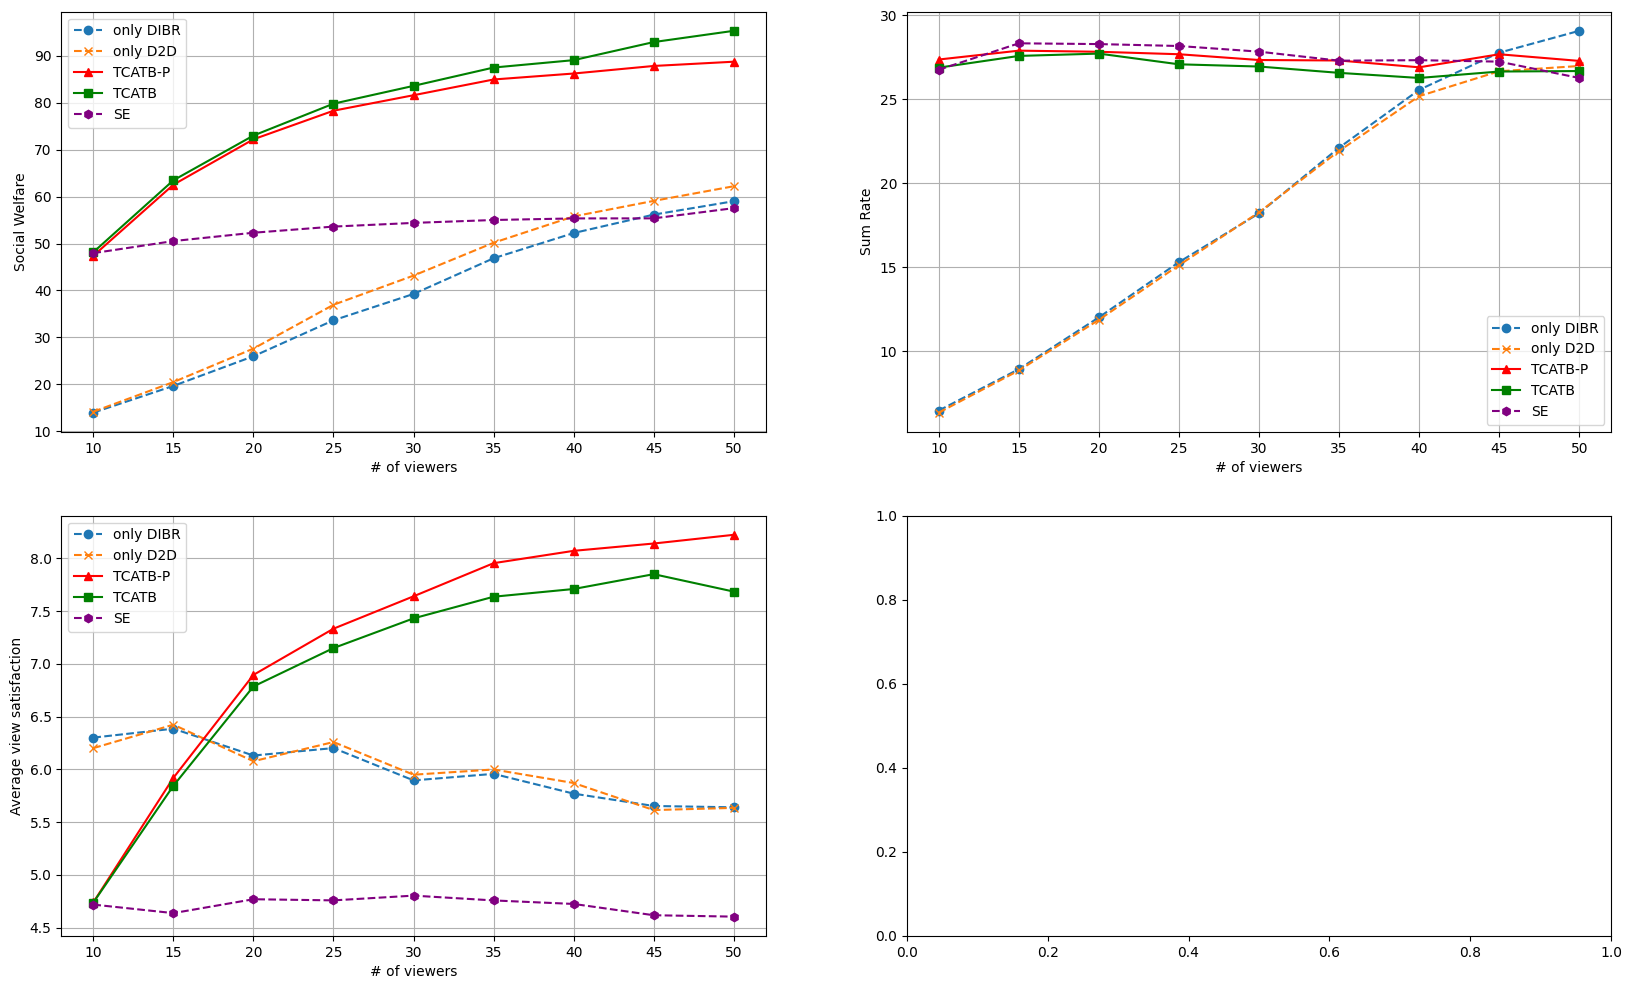

In [ ]:
# Default Parameters

V = 5
W = 3
num_viewers=30
num_d2d=10
grid_size=100
BS_capacity = 10
Delta_DIBR = 3
Dist_D2D = grid_size/3

#Transmission
P_B = 30
P_d = 23
N_0 = 9

# Number of viewers vs Social Welfare
exp_num_viewers = [10, 15, 20, 25, 30, 35, 40, 45, 50]
size = len(exp_num_viewers)

only_DIBR_s, only_d2d_s, tcatb_p_s, tcatb_s, s_s = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_dr, only_d2d_dr, tcatb_p_dr, tcatb_dr, s_dr = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_vs, only_d2d_vs, tcatb_p_vs, tcatb_vs, s_vs = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size

round = 10


for i in range(round):
  Viewers = initiateViewer(0, V, W, 5, num_d2d, grid_size)
  D2Ds = initiateD2D(0, V, W, num_d2d, grid_size)

  for u in range(size):

    n = exp_num_viewers[u]

    #U, Viewers, D2Ds, bs = initiateBS(V, W, num_viewers, num_d2d, grid_size, BS_capacity)
    U, bs = initiateBS(V, W, grid_size, BS_capacity)
    Viewers += initiateViewer(len(Viewers), V, W, 5, num_d2d, grid_size)

    Transmitters = [bs] + D2Ds

    D_CE, D_D2D = MDMT(Viewers, Transmitters, Dist_D2D)
    D_CE_onlyD2D, D_D2D_onlyD2D = MDMT_onlyD2D(Viewers, Transmitters, Dist_D2D)

    LP_set = CDLC(D_CE, D_D2D, P_B, P_d, N_0)
    LP_set_onlyD2D = CDLC(D_CE_onlyD2D, D_D2D_onlyD2D, P_B, P_d, N_0)

    _, _, _, tcatb_p_u, tcatb_p_r, tcatb_p_v = TCATB_P(LP_set, BS_capacity, n)
    # greedy_u, greedy_r, greedy_v, tcatb_p_u, tcatb_p_r, tcatb_p_v = TCATB_P(LP_set, BS_capacity, n)
    #s_u, s_r = SE(LP_set, BS_capacity, n)
    s_u, s_r, s_v = SE2(LP_set, BS_capacity, Viewers, Transmitters)
    tcatb_u, tcatb_r, tcatb_v = TCATB(LP_set, BS_capacity, Viewers, Transmitters)
    greedy_u, greedy_r, greedy_v = only_DIBR(LP_set_onlyD2D, BS_capacity, n)
    #only_D2D_u, only_D2D_r, only_D2D_v = TCATB(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    # _,_,_,only_D2D_u, only_D2D_r, only_D2D_v = TCATB_P(LP_set_onlyD2D, BS_capacity, n)
    only_D2D_u, only_D2D_r, only_D2D_v = SE2(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)

    print("Only-DIBR:", greedy_u)  # Print output to console
    print("Only-D2D:", only_D2D_u)  # Print output to console
    print("TCATB-P:", tcatb_p_u)  # Print output to console
    print("TCATB:", tcatb_u)  # Print output to console
    print("Stackelberg:", s_u)  # Print output to console

    only_DIBR_s[u] += (greedy_u)
    only_d2d_s[u] += (only_D2D_u)
    tcatb_p_s[u] += (tcatb_p_u)
    tcatb_s[u] += (tcatb_u)
    s_s[u] += (s_u)

    only_DIBR_dr[u] += (greedy_r)
    only_d2d_dr[u] += (only_D2D_r)
    tcatb_p_dr[u] += (tcatb_p_r)
    tcatb_dr[u] += (tcatb_r)
    s_dr[u] += (s_r)

    only_DIBR_vs[u] += (greedy_u)/(greedy_v)
    only_d2d_vs[u] += (only_D2D_u)/(only_D2D_v)
    tcatb_p_vs[u] += (tcatb_p_u)/(tcatb_p_v)
    tcatb_vs[u] += (tcatb_u)/(tcatb_v)
    s_vs[u] += (s_u)/(s_v)

for i in range(size):
  only_DIBR_s[i] /= round
  only_d2d_s[i] /= round
  tcatb_p_s[i] /= round
  tcatb_s[i] /= round
  s_s[i] /= round

  only_DIBR_dr[i] /= round
  only_d2d_dr[i] /= round
  tcatb_p_dr[i] /= round
  tcatb_dr[i] /= round
  s_dr[i] /= round

  only_DIBR_vs[i] /= round
  only_d2d_vs[i] /= round
  tcatb_p_vs[i] /= round
  tcatb_vs[i] /= round
  s_vs[i] /= round

print("X-axis:", exp_num_viewers)  # Print output to console
print("Social Welfare:")  # Print output to console
print("Only DIBR:", only_DIBR_s)  # Print output to console
print("Only D2D:", only_d2d_s)  # Print output to console
print("SE:", s_s)  # Print output to console
print("TCATB-P:", tcatb_p_s)  # Print output to console
print("TCATB:", tcatb_s)  # Print output to console

print("Sum Rate:")  # Print output to console
print("Only DIBR:", only_DIBR_dr)  # Print output to console
print("Only D2D:", only_d2d_dr)  # Print output to console
print("SE:", s_dr)  # Print output to console
print("TCATB-P:", tcatb_p_dr)  # Print output to console
print("TCATB:", tcatb_dr)  # Print output to console

print("Average view satisfaction:")  # Print output to console
print("Only DIBR:", only_DIBR_vs)  # Print output to console
print("Only D2D:", only_d2d_vs)  # Print output to console
print("SE:", s_vs)  # Print output to console
print("TCATB-P:", tcatb_p_vs)  # Print output to console
print("TCATB:", tcatb_vs)  # Print output to console

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# First plot on the left
axs[0,0].plot(exp_num_viewers, only_DIBR_s, label='only DIBR', linestyle='dashed', marker='o')
axs[0,0].plot(exp_num_viewers, only_d2d_s, label='only D2D', linestyle='dashed', marker='x')
axs[0,0].plot(exp_num_viewers, tcatb_p_s, label='TCATB-P', marker='^', color='red')
axs[0,0].plot(exp_num_viewers, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_num_viewers, s_s, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('# of viewers')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_num_viewers, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_num_viewers, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_num_viewers, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_num_viewers, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_num_viewers, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('# of viewers')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_num_viewers, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_num_viewers, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_num_viewers, tcatb_p_vs, label='TCATB-P', marker='^', color='red')
axs[1,0].plot(exp_num_viewers, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_num_viewers, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('# of viewers')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

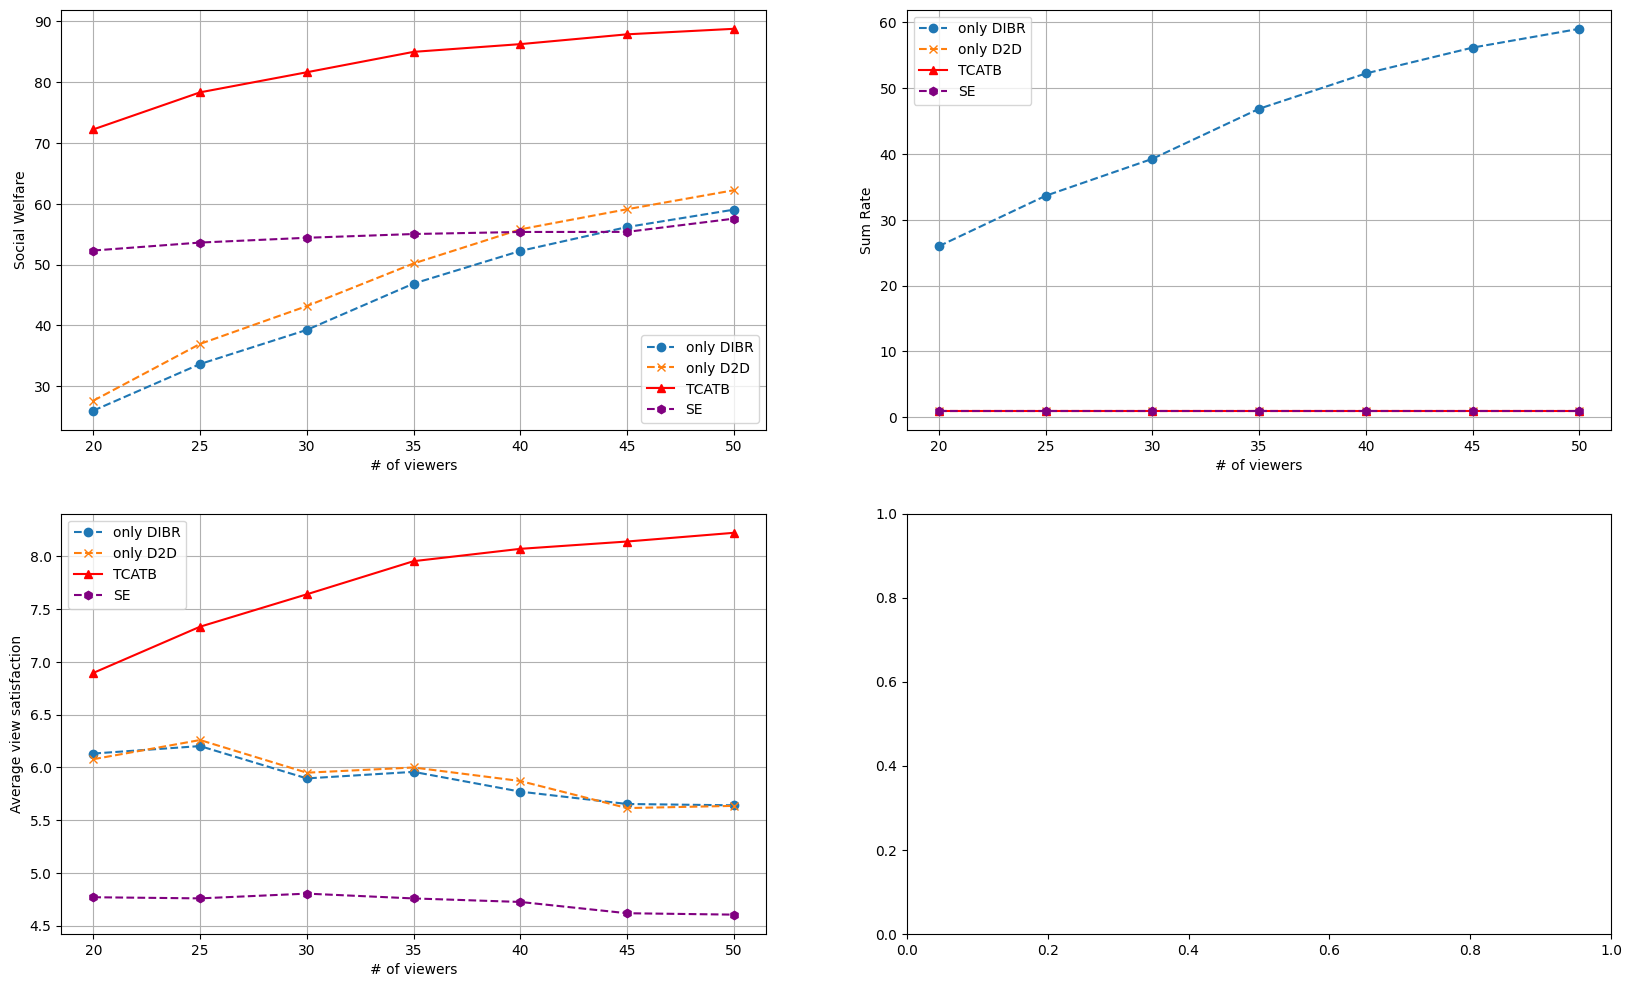

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

exp_num_viewers = [20,25,30,35,40,45,50]
only_DIBR_s = [25.985496106872983, 33.64576797586866, 39.261296998799864, 46.87168433281794, 52.24352701836019, 56.16958326688327, 59.0292490877619]
only_d2d_s = [27.61809899298833, 36.95450785449006, 43.17276959839011, 50.180424211439345, 55.79074286564935, 59.09707714584023, 62.220312424061454]
tcatb_p_s = [72.22243184585136, 78.31640101951983, 81.62091946217602, 84.97313291699977, 86.24390023487686, 87.85559766306186, 88.76266835293768]
tcatb_s = [73.0199322677743, 79.81616281084611, 83.61280628111498, 87.51893710281175, 89.09424883942457, 92.9483015664554, 95.34691212567176]
s_s = [52.30853971846583, 53.61912084017414, 54.405313610320476, 55.023372582403304, 55.361010508001776, 55.37423067763051, 57.550874312113386]


only_DIBR_dr = [1]*7
only_d2d_dr = [1]*7
tcatb_p_dr = [1]*7
tcatb_dr = [1]*7
s_dr = [1]*7

only_DIBR_vs = [6.130449366797054, 6.201168085247973, 5.895014485058773, 5.957020408992833, 5.769552737759502, 5.65264987067509, 5.64003208456077]
only_d2d_vs = [6.076749878037575, 6.258327201053864, 5.949044230197755, 5.99843725964333, 5.870205781891753, 5.613974054539275, 5.634682296966575]
s_vs = [4.7693203792590815, 4.758542214991469, 4.803487204240991, 4.758002753080467, 4.724673182740967, 4.617807275883965, 4.604552339035414]
tcatb_p_vs = [6.8942157347565285, 7.331943622051102, 7.638826694113331, 7.952668861163369, 8.069494614986922, 8.138816112159379, 8.221277083966273]
tcatb_vs = [6.784993073957695, 7.148440389354131, 7.429781777447404, 7.634841883885409, 7.707989757444845, 7.848457434293012, 7.683267308688931]




# First plot on the left
axs[0,0].plot(exp_num_viewers, only_DIBR_s, label='only DIBR', linestyle='dashed', marker='o')
axs[0,0].plot(exp_num_viewers, only_d2d_s, label='only D2D', linestyle='dashed', marker='x')
axs[0,0].plot(exp_num_viewers, tcatb_p_s, label='TCATB', marker='^', color='red')
#axs[0,0].plot(exp_num_viewers, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_num_viewers, s_s, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('# of viewers')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_num_viewers, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_num_viewers, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_num_viewers, tcatb_p_dr, label='TCATB', marker='^', color='red')
# axs[0,1].plot(exp_num_viewers, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_num_viewers, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('# of viewers')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_num_viewers, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_num_viewers, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_num_viewers, tcatb_p_vs, label='TCATB', marker='^', color='red')
# axs[1,0].plot(exp_num_viewers, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_num_viewers, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('# of viewers')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

In [ ]:
import csv  # Import required module
with open('#ofviewer.csv', 'w', newline='') as csvfile:

  # 以空白分隔欄位，建立 CSV 檔寫入器
  writer = csv.writer(csvfile, delimiter=',')

  writer.writerow(["X-axis"]+exp_num_viewers)
  writer.writerow(["Social Welfare"])
  writer.writerow(['Only DIBR']+only_DIBR_s)
  writer.writerow(['Only D2D']+only_d2d_s)
  writer.writerow(['SE']+s_s)
  writer.writerow(['TCATB-P']+tcatb_p_s)
  writer.writerow(['TCATB']+tcatb_s)
  writer.writerow(["Sum Rate"])
  writer.writerow(['Only DIBR']+only_DIBR_dr)
  writer.writerow(['Only D2D']+only_d2d_dr)
  writer.writerow(['SE']+s_dr)
  writer.writerow(['TCATB-P']+tcatb_p_dr)
  writer.writerow(['TCATB']+tcatb_dr)
  writer.writerow(["Average view satisfaction"])
  writer.writerow(['Only DIBR']+only_DIBR_vs)
  writer.writerow(['Only D2D']+only_d2d_vs)
  writer.writerow(['SE']+s_vs)
  writer.writerow(['TCATB-P']+tcatb_p_vs)
  writer.writerow(['TCATB']+tcatb_vs)

# **# of D2D - Social Welfare**

TCATB-P:
Viewers: Viewer  13 Transmitters: BS Utility: 8.965181359543081
Datarate: 1.9210356204667192
Viewers: Viewer  16 Transmitters: BS Utility: 8.934221903535676
Datarate: 3.439503459244873
Viewers: Viewer  18 Transmitters: BS Utility: 8.865645325040303
Datarate: 3.386819229119526
Viewers: Viewer  7 Transmitters: BS Utility: 8.663117923300375
Datarate: 3.2291044455426006
Viewers: Viewer  19 Transmitters: BS Utility: 8.238392710387572
Datarate: 2.9063780479430634
Viewers: Viewer  17 Transmitters: BS Utility: 8.019583608172404
Datarate: 2.614240062208757
Viewers: Viewer  22 Transmitters: BS Utility: 7.53010729454779
Datarate: 2.9685129046911722
Viewers: Viewer  4 Transmitters: BS Utility: 7.428715665239627
Datarate: 3.583684236647211
Viewers: Viewer  2 Transmitters: BS Utility: 7.0500121113684155
Datarate: 3.3309190839563914
Viewers: Viewer  9 Transmitters: BS Utility: 6.980244905606198
Datarate: 3.455659976549598

Status: Optimal
Optimal subset includes:
Viewers: Viewer  2 Transmitt

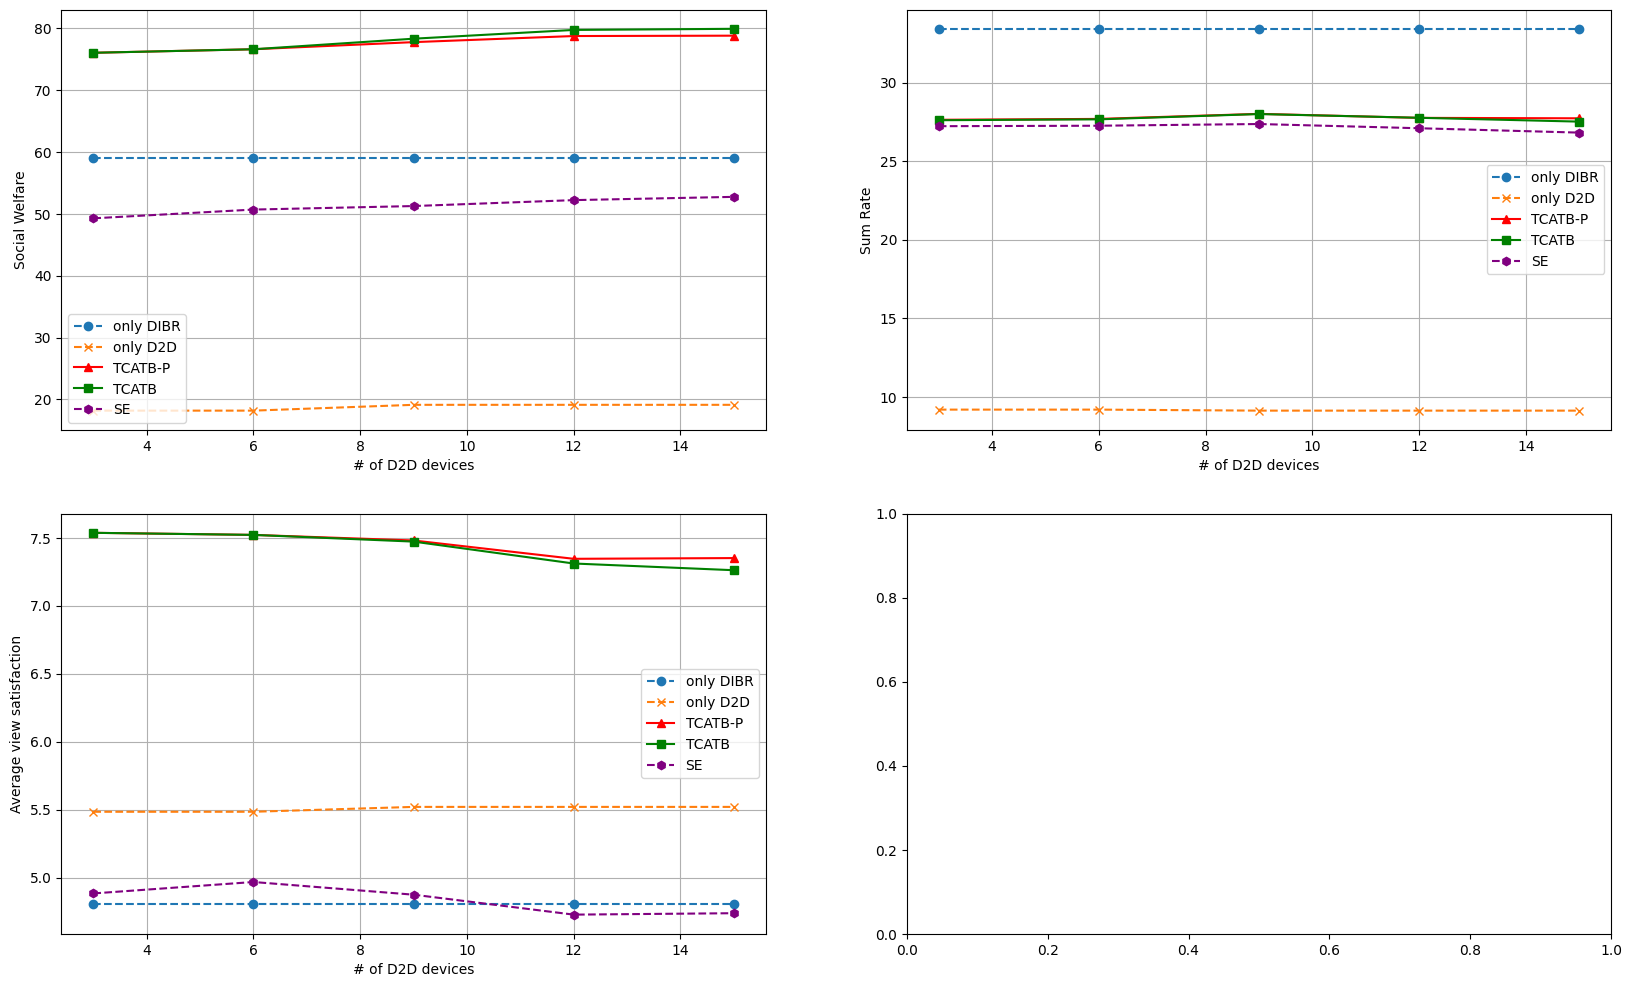

In [ ]:
# Default Parameters

V = 10
W = 3
num_viewers=30
num_d2d=10
grid_size=100
BS_capacity = 10
Delta_DIBR = 3
Dist_D2D = grid_size/3

#Transmission
P_B = 30
P_d = 23
N_0 = 9

# Number of d2d vs Social Welfare
exp_num_d2ds = [3, 6, 9, 12, 15]

size = len(exp_num_d2ds)

only_DIBR_s, only_d2d_s, tcatb_p_s, tcatb_s, s_s = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_dr, only_d2d_dr, tcatb_p_dr, tcatb_dr, s_dr = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_vs, only_d2d_vs, tcatb_p_vs, tcatb_vs, s_vs = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size

round = 10

for i in range(round):
  Viewers = initiateViewer(0, V, W, num_viewers, 0, grid_size)
  D2Ds = []
  U, bs = initiateBS(V, W, grid_size, BS_capacity)

  for u in range(size):

    n = exp_num_d2ds[u]
    for v in Viewers:
      v.channel_states += randomChannelStates(3)

    D2Ds += initiateD2D(len(D2Ds), V, W, 3, grid_size)
    Transmitters = [bs] + D2Ds

    D_CE, D_D2D = MDMT(Viewers, Transmitters, Dist_D2D)
    D_CE_onlyD2D, D_D2D_onlyD2D = MDMT_onlyD2D(Viewers, Transmitters, Dist_D2D)

    LP_set = CDLC(D_CE, D_D2D, P_B, P_d, N_0)
    LP_set_onlyD2D = CDLC(D_CE_onlyD2D, D_D2D_onlyD2D, P_B, P_d, N_0)

    _, _, _, tcatb_p_u, tcatb_p_r, tcatb_p_v = TCATB_P(LP_set, BS_capacity, num_viewers)
    greedy_u, greedy_r, greedy_v = only_DIBR(LP_set, BS_capacity, num_viewers)
    tcatb_u, tcatb_r, tcatb_v = TCATB(LP_set, BS_capacity, Viewers, Transmitters)
    # only_D2D_u, only_D2D_r, only_D2D_v = TCATB(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    only_D2D_u, only_D2D_r, only_D2D_v = SE2(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    s_u, s_r, s_v = SE2(LP_set, BS_capacity, Viewers, Transmitters)

    print("Only-DIBR:", greedy_u)  # Print output to console
    print("Only-D2D:", only_D2D_u)  # Print output to console
    print("TCATB-P:", tcatb_p_u)  # Print output to console
    print("TCATB:", tcatb_u)  # Print output to console
    print("SE:", s_u)  # Print output to console
    only_DIBR_s[u] += (greedy_u)
    only_d2d_s[u] += (only_D2D_u)
    tcatb_p_s[u] += (tcatb_p_u)
    tcatb_s[u] += (tcatb_u)
    s_s[u] += (s_u)

    only_DIBR_dr[u] += (greedy_r)
    only_d2d_dr[u] += (only_D2D_r)
    tcatb_p_dr[u] += (tcatb_p_r)
    tcatb_dr[u] += (tcatb_r)
    s_dr[u] += (s_r)

    only_DIBR_vs[u] += (greedy_u)/(greedy_v)
    only_d2d_vs[u] += (only_D2D_u)/(only_D2D_v)
    tcatb_p_vs[u] += (tcatb_p_u)/(tcatb_p_v)
    tcatb_vs[u] += (tcatb_u)/(tcatb_v)
    s_vs[u] += (s_u)/(s_v)


for i in range(size):
  only_DIBR_s[i] /= round
  only_d2d_s[i] /= round
  tcatb_p_s[i] /= round
  tcatb_s[i] /= round
  s_s[i] /= round

  only_DIBR_dr[i] /= round
  only_d2d_dr[i] /= round
  tcatb_p_dr[i] /= round
  tcatb_dr[i] /= round
  s_dr[i] /= round

  only_DIBR_vs[i] /= round
  only_d2d_vs[i] /= round
  tcatb_p_vs[i] /= round
  tcatb_vs[i] /= round
  s_vs[i] /= round

print("X-axis:", exp_num_d2ds)  # Print output to console
print("Social Welfare:")  # Print output to console
print("Only DIBR:", only_DIBR_s)  # Print output to console
print("Only D2D:", only_d2d_s)  # Print output to console
print("SE:", s_s)  # Print output to console
print("TCATB-P:", tcatb_p_s)  # Print output to console
print("TCATB:", tcatb_s)  # Print output to console

print("Sum Rate:")  # Print output to console
print("Only DIBR:", only_DIBR_dr)  # Print output to console
print("Only D2D:", only_d2d_dr)  # Print output to console
print("SE:", s_dr)  # Print output to console
print("TCATB-P:", tcatb_p_dr)  # Print output to console
print("TCATB:", tcatb_dr)  # Print output to console

print("Average view satisfaction:")  # Print output to console
print("Only DIBR:", only_DIBR_vs)  # Print output to console
print("Only D2D:", only_d2d_vs)  # Print output to console
print("SE:", s_vs)  # Print output to console
print("TCATB-P:", tcatb_p_vs)  # Print output to console
print("TCATB:", tcatb_vs)  # Print output to console

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# First plot on the left
axs[0,0].plot(exp_num_d2ds, only_DIBR_s, label='only DIBR', linestyle='dashed', marker='o')
axs[0,0].plot(exp_num_d2ds, only_d2d_s, label='only D2D', linestyle='dashed', marker='x')
axs[0,0].plot(exp_num_d2ds, tcatb_p_s, label='TCATB-P', marker='^', color='red')
axs[0,0].plot(exp_num_d2ds, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_num_d2ds, s_s, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('# of D2D devices')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_num_d2ds, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_num_d2ds, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_num_d2ds, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_num_d2ds, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_num_d2ds, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('# of D2D devices')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_num_d2ds, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_num_d2ds, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_num_d2ds, tcatb_p_vs, label='TCATB-P', marker='^', color='red')
axs[1,0].plot(exp_num_d2ds, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_num_d2ds, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('# of D2D devices')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

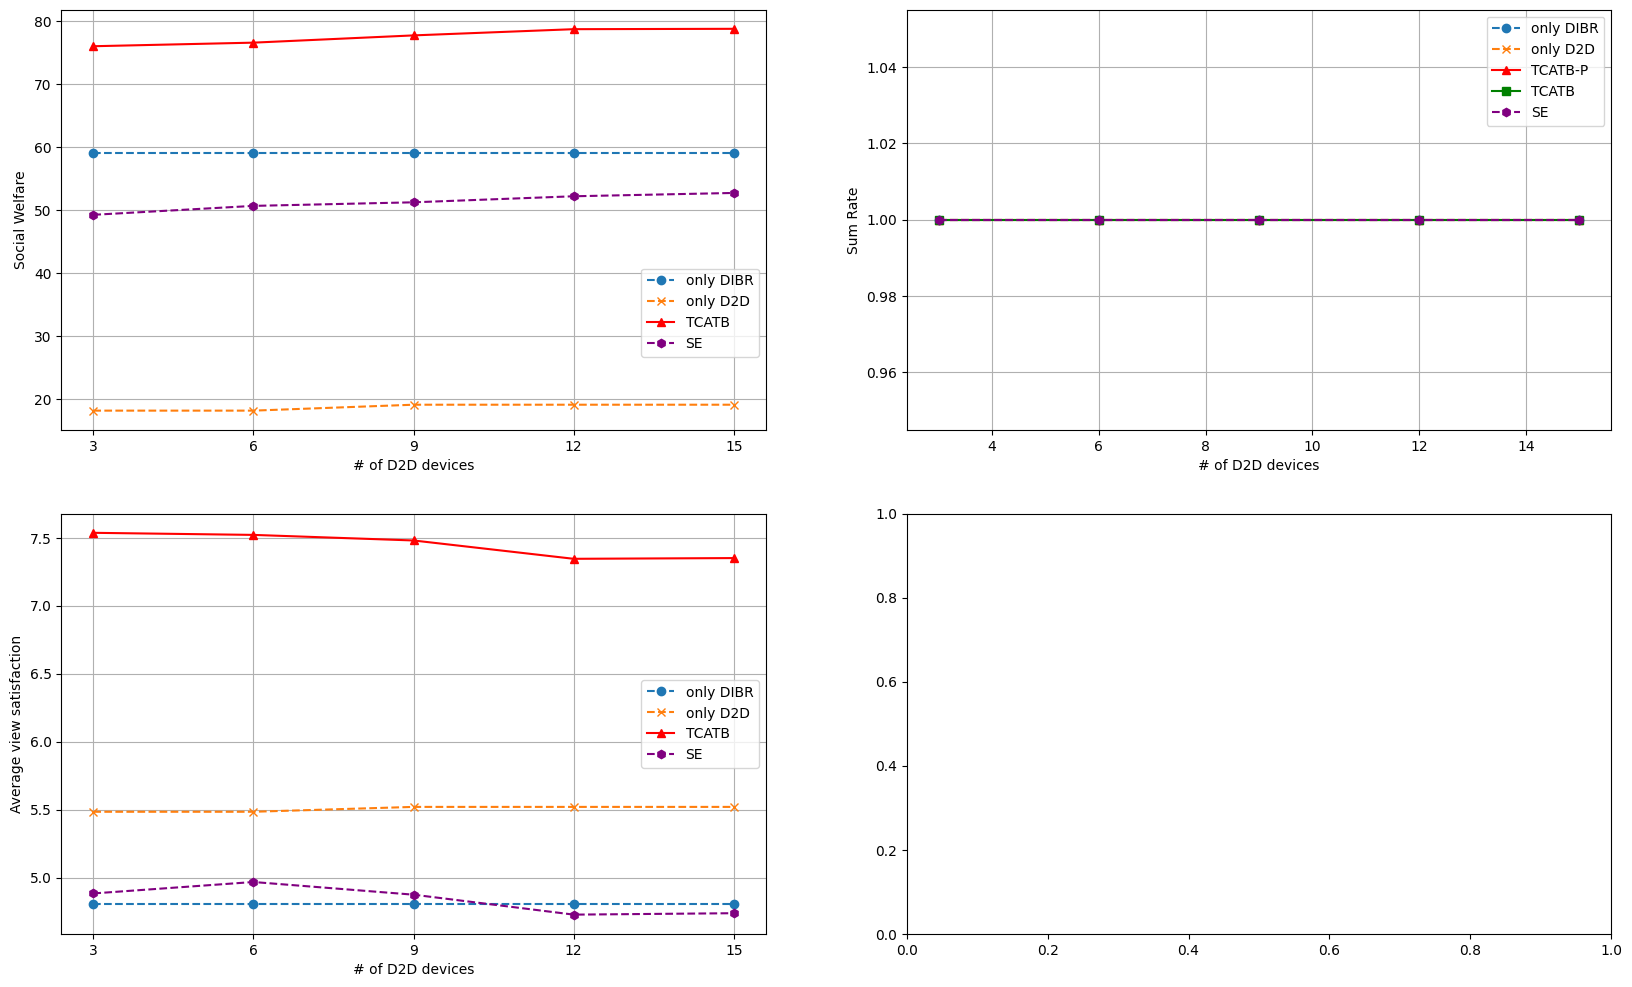

In [13]:
from matplotlib.pyplot import MultipleLocator
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

exp_num_d2ds = [3, 6, 9, 12, 15]

only_DIBR_s = [58.99402544133687, 58.99402544133687, 58.99402544133687, 58.99402544133687, 58.99402544133687]
only_d2d_s = [18.184023877917838, 18.184023877917838, 19.123426208836317, 19.123426208836317, 19.123426208836317]
s_s = [49.2620967924582, 50.67833664884249, 51.246702053447414, 52.20438123299165, 52.73187616108809]
tcatb_p_s = [76.01719499736335, 76.58542237496731, 77.73637639702139, 78.72255171600426, 78.78116582328948]
tcatb_s = [76.01719499736336, 76.58542237496732, 78.29268565916033, 79.70844384641578, 79.88998326500482]

only_DIBR_dr = [1]*5
only_d2d_dr = [1]*5
tcatb_p_dr = [1]*5
tcatb_dr = [1]*5
s_dr = [1]*5

only_DIBR_vs = [4.803945338311038, 4.803945338311038, 4.803945338311038, 4.803945338311038, 4.803945338311038]
only_d2d_vs = [5.484865024385451, 5.484865024385451, 5.52062163180824, 5.52062163180824, 5.52062163180824]
s_vs = [4.884294868325141, 4.968363576805911, 4.875141458070772, 4.728444418267325, 4.738905048538287]
tcatb_p_vs = [7.536108158923588, 7.520792788794917, 7.4797882251472725, 7.344985229653839, 7.350313784861586]
tcatb_vs = [7.536108158923589, 7.520792788794918, 7.471471212981564, 7.31044287053952, 7.2611003462838655]


x_major_locator = MultipleLocator(3)

# First plot on the left
axs[0,0].plot(exp_num_d2ds, only_DIBR_s, label='only DIBR', linestyle='dashed', marker='o')
axs[0,0].plot(exp_num_d2ds, only_d2d_s, label='only D2D', linestyle='dashed', marker='x')
axs[0,0].plot(exp_num_d2ds, tcatb_p_s, label='TCATB', marker='^', color='red')
#axs[0,0].plot(exp_num_d2ds, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_num_d2ds, s_s, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('# of D2D devices')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend(bbox_to_anchor=(1, 0.4))
axs[0,0].xaxis.set_major_locator(x_major_locator)
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_num_d2ds, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_num_d2ds, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_num_d2ds, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_num_d2ds, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_num_d2ds, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('# of D2D devices')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_num_d2ds, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_num_d2ds, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_num_d2ds, tcatb_p_vs, label='TCATB', marker='^', color='red')
#axs[1,0].plot(exp_num_d2ds, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_num_d2ds, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('# of D2D devices')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].xaxis.set_major_locator(x_major_locator)
axs[1,0].legend()
axs[1,0].grid(True)

In [ ]:
with open('#ofd2d.csv', 'w', newline='') as csvfile:

  # 以空白分隔欄位，建立 CSV 檔寫入器
  writer = csv.writer(csvfile, delimiter=',')

  writer.writerow(["X-axis"]+exp_num_d2ds)
  writer.writerow(["Social Welfare"])
  writer.writerow(['Only DIBR']+only_DIBR_s)
  writer.writerow(['Only D2D']+only_d2d_s)
  writer.writerow(['SE']+s_s)
  writer.writerow(['TCATB-P']+tcatb_p_s)
  writer.writerow(['TCATB']+tcatb_s)
  writer.writerow(["Sum Rate"])
  writer.writerow(['Only DIBR']+only_DIBR_dr)
  writer.writerow(['Only D2D']+only_d2d_dr)
  writer.writerow(['SE']+s_dr)
  writer.writerow(['TCATB-P']+tcatb_p_dr)
  writer.writerow(['TCATB']+tcatb_dr)
  writer.writerow(["Average view satisfaction"])
  writer.writerow(['Only DIBR']+only_DIBR_vs)
  writer.writerow(['Only D2D']+only_d2d_vs)
  writer.writerow(['SE']+s_vs)
  writer.writerow(['TCATB-P']+tcatb_p_vs)
  writer.writerow(['TCATB']+tcatb_vs)

# **Bandwidth size - Social Welfare**

串流輸出內容已截斷至最後 5000 行。
Viewers: Viewer  27 Transmitters: BS Utility: 9.12175290390833
Datarate: 3.475491936870797
Viewers: Viewer  6 Transmitters: BS Utility: 8.814051042525378
Datarate: 3.0272833132859516
Viewers: Viewer  8 Transmitters: BS Utility: 8.60429846810333
Datarate: 2.4495363033764566
Viewers: Viewer  12 Transmitters: BS Utility: 8.51454397694334
Datarate: 3.664984660365442
Viewers: Viewer  15 Transmitters: BS Utility: 7.679162498759659
Datarate: 2.8950270741808106
Viewers: Viewer  10 Transmitters: BS Utility: 7.041563885344287
Datarate: 3.5932956976442068
Viewers: Viewer  18 Transmitters: BS Utility: 6.774446825842586
Datarate: 2.3566907695082047
Viewers: Viewer  1 Transmitters: BS Utility: 6.14673707716968
Datarate: 2.517771985745375
Viewers: Viewer  14 Transmitters: BS Utility: 6.088992994523331
Datarate: 3.0994503229985155
Viewers: Viewer  22 Transmitters: BS Utility: 5.331212753257068
Datarate: 1.5107172160136024
Viewers: Viewer  28 Transmitters: BS Utility: 5.02532823827

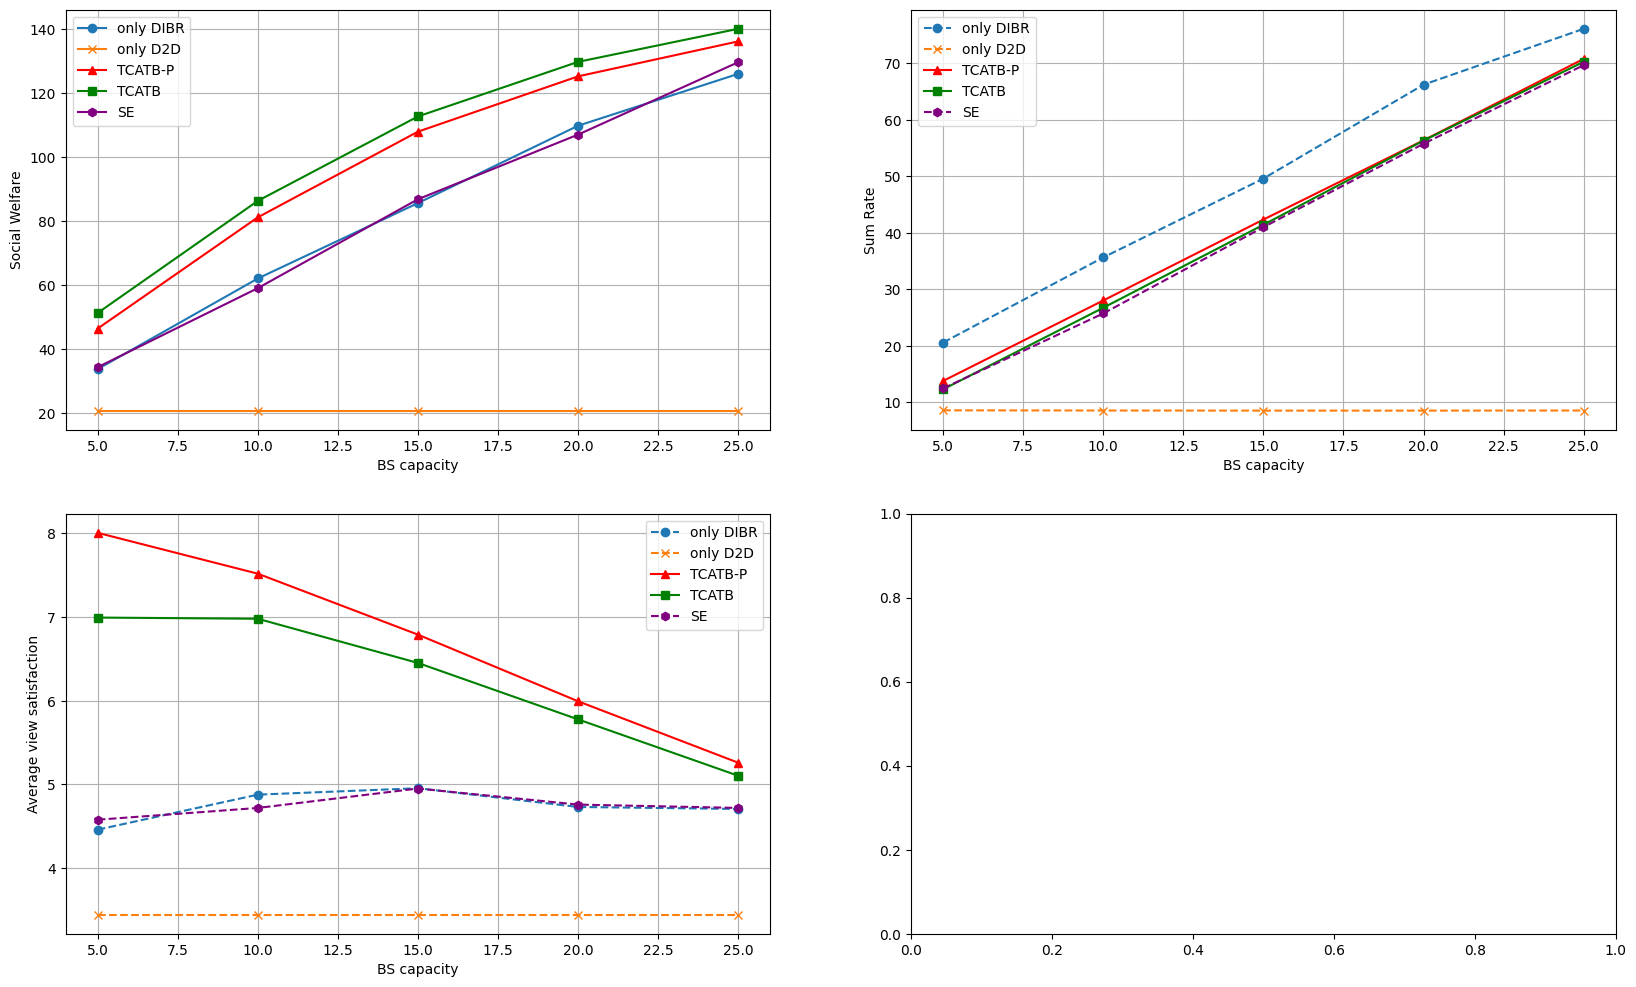

In [ ]:
# Default Parameters

V = 10
W = 3
num_viewers=30
num_d2d=20
grid_size=100
BS_capacity = 10
Delta_DIBR = 3
Dist_D2D = grid_size/3

#Transmission
P_B = 30
P_d = 23
N_0 = 9

# Number of viewers vs Social Welfare
exp_BS_cap = [5, 10, 15, 20, 25]
size = len(exp_BS_cap)

only_DIBR_s, only_d2d_s, tcatb_p_s, tcatb_s, s_s = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_dr, only_d2d_dr, tcatb_p_dr, tcatb_dr, s_dr = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_vs, only_d2d_vs, tcatb_p_vs, tcatb_vs, s_vs = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size

round = 10

for i in range(round):

  Viewers = initiateViewer(0, V, W, num_viewers, num_d2d, grid_size)
  D2Ds = initiateD2D(0, V, W, num_d2d, grid_size)

  for u in range(len(exp_BS_cap)):
    n = exp_BS_cap[u]
    U, bs = initiateBS(V, W, grid_size, n)
    Transmitters = [bs] + D2Ds

    D_CE, D_D2D = MDMT(Viewers, Transmitters, Dist_D2D)
    D_CE_onlyD2D, D_D2D_onlyD2D = MDMT_onlyD2D(Viewers, Transmitters, Dist_D2D)

    LP_set = CDLC(D_CE, D_D2D, P_B, P_d, N_0)
    LP_set_onlyD2D = CDLC(D_CE_onlyD2D, D_D2D_onlyD2D, P_B, P_d, N_0)

    _, _, _, tcatb_p_u, tcatb_p_r, tcatb_p_v = TCATB_P(LP_set, n, num_viewers)
    greedy_u, greedy_r, greedy_v = only_DIBR(LP_set, n, num_viewers)
    tcatb_u, tcatb_r, tcatb_v = TCATB(LP_set, n, Viewers, Transmitters)
    # only_D2D_u, only_D2D_r, onlt_D2D_v = TCATB(LP_set_onlyD2D, n, Viewers, Transmitters)
    only_D2D_u, only_D2D_r, onlt_D2D_v = SE2(LP_set_onlyD2D, n, Viewers, Transmitters)
    s_u, s_r, s_v = SE2(LP_set, n, Viewers, Transmitters)

    print("Only-DIBR:", greedy_u)  # Print output to console
    print("Only-D2D:", only_D2D_u)  # Print output to console
    print("TCATB-P:", tcatb_p_u)  # Print output to console
    print("TCATB:", tcatb_u)  # Print output to console
    print("SE:", s_u)  # Print output to console

    only_DIBR_s[u] += (greedy_u)
    only_d2d_s[u] += (only_D2D_u)
    tcatb_p_s[u] += (tcatb_p_u)
    tcatb_s[u] += (tcatb_u)
    s_s[u] += (s_u)

    only_DIBR_dr[u] += (greedy_r)
    only_d2d_dr[u] += (only_D2D_r)
    tcatb_p_dr[u] += (tcatb_p_r)
    tcatb_dr[u] += (tcatb_r)
    s_dr[u] += (s_r)

    only_DIBR_vs[u] += (greedy_u)/(greedy_v)
    only_d2d_vs[u] += (only_D2D_u)/(only_D2D_v)
    tcatb_p_vs[u] += (tcatb_p_u)/(tcatb_p_v)
    tcatb_vs[u] += (tcatb_u)/(tcatb_v)
    s_vs[u] += (s_u)/(s_v)

for i in range(size):
  only_DIBR_s[i] /= round
  only_d2d_s[i] /= round
  tcatb_p_s[i] /= round
  tcatb_s[i] /= round
  s_s[i] /= round

  only_DIBR_dr[i] /= round
  only_d2d_dr[i] /= round
  tcatb_p_dr[i] /= round
  tcatb_dr[i] /= round
  s_dr[i] /= round

  only_DIBR_vs[i] /= round
  only_d2d_vs[i] /= round
  tcatb_p_vs[i] /= round
  tcatb_vs[i] /= round
  s_vs[i] /= round

print("X-axis:", exp_BS_cap)  # Print output to console
print("Social Welfare:")  # Print output to console
print("Only DIBR:", only_DIBR_s)  # Print output to console
print("Only D2D:", only_d2d_s)  # Print output to console
print("SE:", s_s)  # Print output to console
print("TCATB-P:", tcatb_p_s)  # Print output to console
print("TCATB:", tcatb_s)  # Print output to console

print("Sum Rate:")  # Print output to console
print("Only DIBR:", only_DIBR_dr)  # Print output to console
print("Only D2D:", only_d2d_dr)  # Print output to console
print("SE:", s_dr)  # Print output to console
print("TCATB-P:", tcatb_p_dr)  # Print output to console
print("TCATB:", tcatb_dr)  # Print output to console

print("Average view satisfaction:")  # Print output to console
print("Only DIBR:", only_DIBR_vs)  # Print output to console
print("Only D2D:", only_d2d_vs)  # Print output to console
print("SE:", s_vs)  # Print output to console
print("TCATB-P:", tcatb_p_vs)  # Print output to console
print("TCATB:", tcatb_vs)  # Print output to console

fig, axs = plt.subplots(2, 2, figsize=(20, 12)) # Adjusting the figsize to accommodate both plots

# First plot on the left
axs[0,0].plot(exp_BS_cap, only_DIBR_s, label='only DIBR', marker='o')
axs[0,0].plot(exp_BS_cap, only_d2d_s, label='only D2D', marker='x')
axs[0,0].plot(exp_BS_cap, tcatb_p_s, label='TCATB-P', marker='^', color='red')
axs[0,0].plot(exp_BS_cap, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_BS_cap, s_s, label='SE', marker='h', color='purple')
axs[0,0].set_xlabel('BS capacity')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_BS_cap, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_BS_cap, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_BS_cap, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_BS_cap, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_BS_cap, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('BS capacity')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_BS_cap, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_BS_cap, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_BS_cap, tcatb_p_vs, label='TCATB-P', marker='^', color='red')
axs[1,0].plot(exp_BS_cap, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_BS_cap, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('BS capacity')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

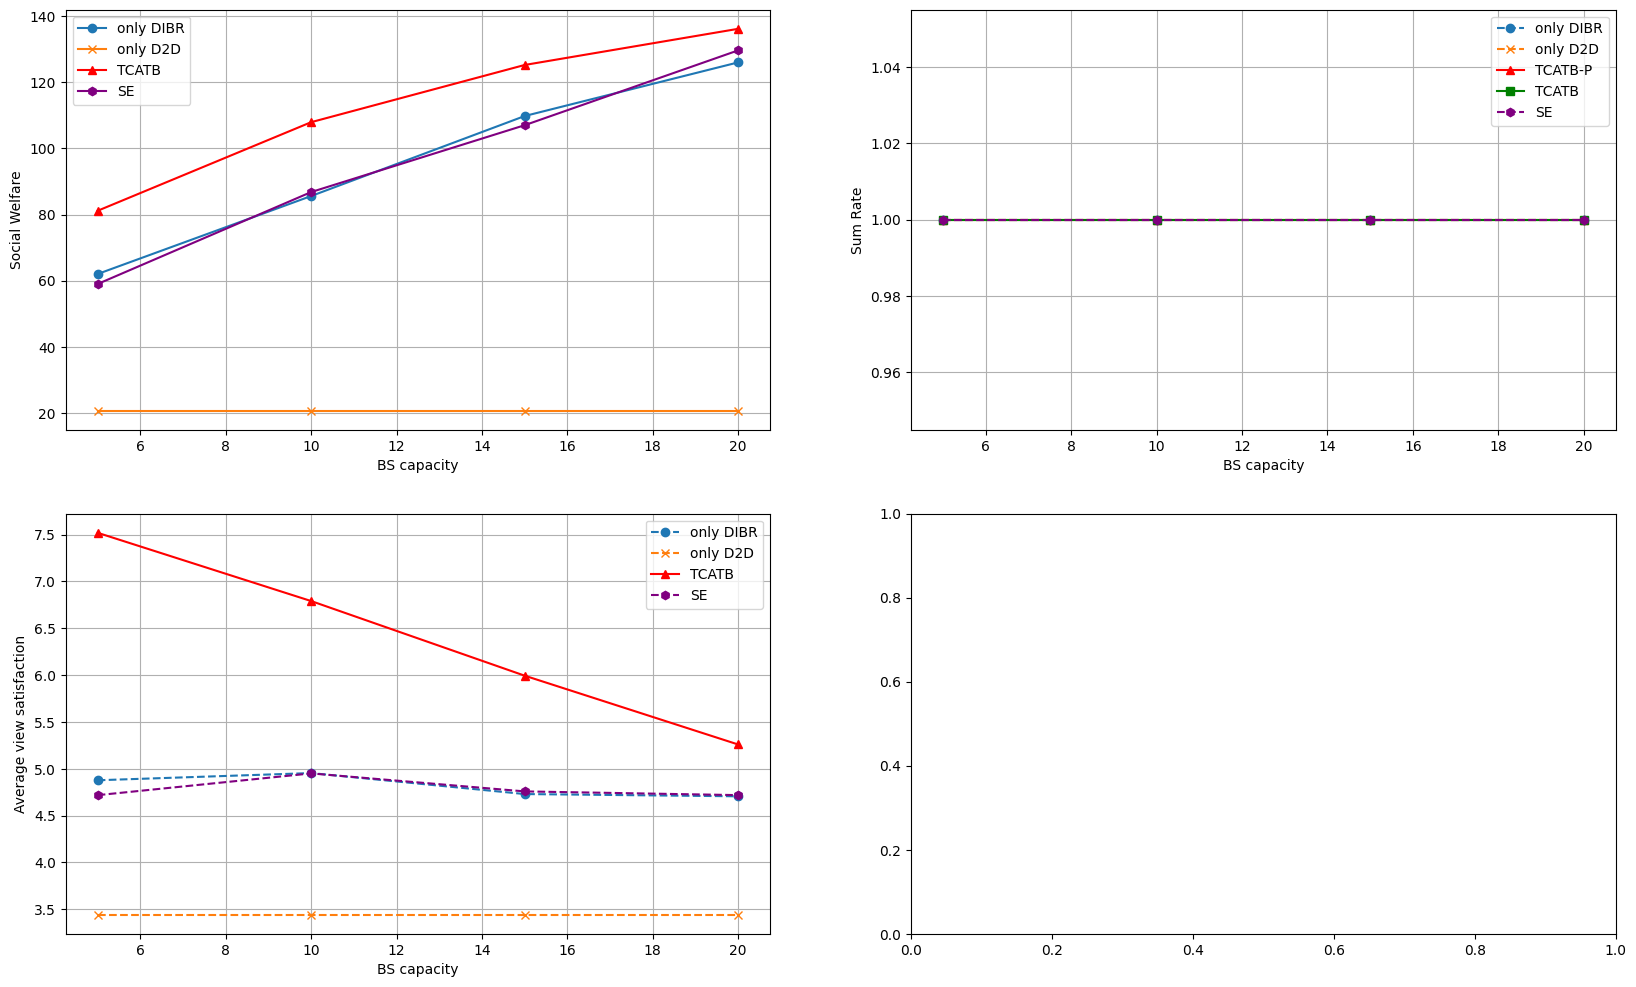

In [14]:
exp_BS_cap = [5, 10, 15, 20]

only_DIBR_s = [62.017676695618185, 85.61266463920941, 109.82151451494205, 126.05720393963034]
only_d2d_s = [20.660430425500902, 20.660430425500902, 20.660430425500902, 20.660430425500902]
s_s = [58.99361389095948, 86.81290922753318, 107.04594527490408, 129.69370208548966]
tcatb_p_s = [81.15223823469748, 107.96330549513993, 125.2736609468446, 136.21711986053703]
tcatb_s = [86.30755551036279, 112.72509471701282, 129.81207588297212, 140.15536296807957]

only_DIBR_dr = [1]*4
only_d2d_dr = [1]*4
tcatb_p_dr = [1]*4
tcatb_dr = [1]*4
s_dr = [1]*4

only_DIBR_vs = [4.877755883903349, 4.954509572276704, 4.730516848929745, 4.706464280481079]
only_d2d_vs = [3.4434050709168162, 3.4434050709168162, 3.4434050709168162, 3.4434050709168162]
s_vs = [4.718674132749813, 4.950903453375391, 4.758828781985359, 4.719173688489232]
tcatb_p_vs = [7.519174874965302, 6.790577084430725, 5.9940868042010775, 5.259595043133193]
tcatb_vs = [6.980304340239653, 6.4522469096040895, 5.777650051311723, 5.103774589396928]

fig, axs = plt.subplots(2, 2, figsize=(20, 12)) # Adjusting the figsize to accommodate both plots

# First plot on the left
axs[0,0].plot(exp_BS_cap, only_DIBR_s, label='only DIBR', marker='o')
axs[0,0].plot(exp_BS_cap, only_d2d_s, label='only D2D', marker='x')
axs[0,0].plot(exp_BS_cap, tcatb_p_s, label='TCATB', marker='^', color='red')
#axs[0,0].plot(exp_BS_cap, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_BS_cap, s_s, label='SE', marker='h', color='purple')
axs[0,0].set_xlabel('BS capacity')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_BS_cap, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_BS_cap, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_BS_cap, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_BS_cap, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_BS_cap, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('BS capacity')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_BS_cap, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_BS_cap, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_BS_cap, tcatb_p_vs, label='TCATB', marker='^', color='red')
#axs[1,0].plot(exp_BS_cap, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_BS_cap, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('BS capacity')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

In [ ]:
with open('BScapacity.csv', 'w', newline='') as csvfile:

  # 以空白分隔欄位，建立 CSV 檔寫入器
  writer = csv.writer(csvfile, delimiter=',')

  writer.writerow(["X-axis"]+exp_BS_cap)
  writer.writerow(["Social Welfare"])
  writer.writerow(['Only DIBR']+only_DIBR_s)
  writer.writerow(['Only D2D']+only_d2d_s)
  writer.writerow(['SE']+s_s)
  writer.writerow(['TCATB-P']+tcatb_p_s)
  writer.writerow(['TCATB']+tcatb_s)
  writer.writerow(["Sum Rate"])
  writer.writerow(['Only DIBR']+only_DIBR_dr)
  writer.writerow(['Only D2D']+only_d2d_dr)
  writer.writerow(['SE']+s_dr)
  writer.writerow(['TCATB-P']+tcatb_p_dr)
  writer.writerow(['TCATB']+tcatb_dr)
  writer.writerow(["Average view satisfaction"])
  writer.writerow(['Only DIBR']+only_DIBR_vs)
  writer.writerow(['Only D2D']+only_d2d_vs)
  writer.writerow(['SE']+s_vs)
  writer.writerow(['TCATB-P']+tcatb_p_vs)
  writer.writerow(['TCATB']+tcatb_vs)

# **View Width - Social Welfare**

TCATB-P:
Viewers: Viewer  4 Transmitters: BS Utility: 8.922111047181271
Datarate: 2.8964850049966255
Viewers: Viewer  19 Transmitters: BS Utility: 8.16414551907804
Datarate: 2.833069941970128
Viewers: Viewer  11 Transmitters: BS Utility: 7.464812204817214
Datarate: 3.392802006132807
Viewers: Viewer  28 Transmitters: BS Utility: 7.360362217006955
Datarate: 3.5824528900318895
Viewers: Viewer  23 Transmitters: BS Utility: 6.850999966958485
Datarate: 3.4317494735443486
Viewers: Viewer  21 Transmitters: BS Utility: 6.505515084426699
Datarate: 2.768618365874586
Viewers: Viewer  6 Transmitters: BS Utility: 6.443124560996138
Datarate: 2.585760518563828
Viewers: Viewer  3 Transmitters: BS Utility: 6.402912384254111
Datarate: 3.7345596782488926
Viewers: Viewer  30 Viewer  20 Transmitters: BS D2D# 5 Utility: 12.736099939908732
Datarate: 1.751230014797085
Viewers: Viewer  5 Transmitters: BS Utility: 6.39345304090708
Datarate: 3.619322195913955

Status: Optimal
Optimal subset includes:
Viewers: Vie

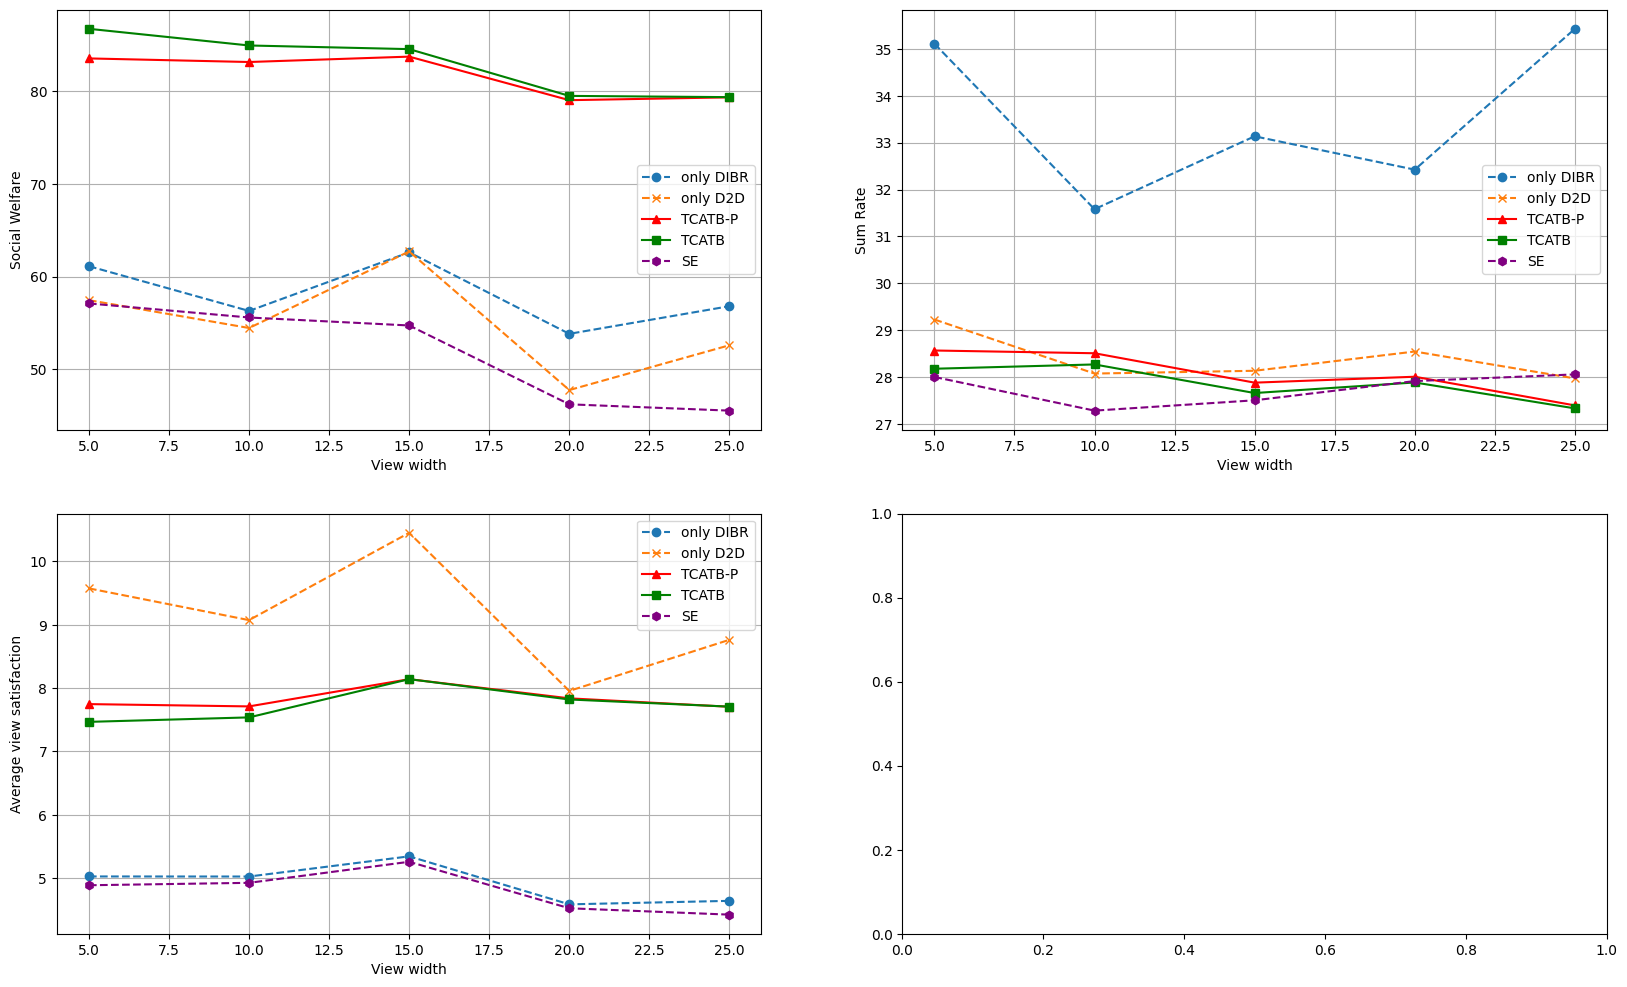

In [ ]:
# Default Parameters

V = 5
W = 2
num_viewers=30
num_d2d=10
grid_size=100
BS_capacity = 10
Delta_DIBR = 3
Dist_D2D = grid_size/3

#Transmission
P_B = 30
P_d = 23
N_0 = 9

# Number of viewers vs Social Welfare
exp_V = [5, 10, 15, 20, 25]
size = len(exp_V)

only_DIBR_s, only_d2d_s, tcatb_p_s, tcatb_s, s_s = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_dr, only_d2d_dr, tcatb_p_dr, tcatb_dr, s_dr = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_vs, only_d2d_vs, tcatb_p_vs, tcatb_vs, s_vs = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size

round = 10

for i in range(round):
  for u in range(size):
    n = exp_V[u]

    U, bs = initiateBS(n, W, grid_size, BS_capacity)
    Viewers = initiateViewer(0, n, W, num_viewers, num_d2d, grid_size)
    D2Ds = initiateD2D(0, n, W, num_d2d, grid_size)
    Transmitters = [bs] + D2Ds

    D_CE, D_D2D = MDMT(Viewers, Transmitters, Dist_D2D)
    D_CE_onlyD2D, D_D2D_onlyD2D = MDMT_onlyD2D(Viewers, Transmitters, Dist_D2D)

    LP_set = CDLC(D_CE, D_D2D, P_B, P_d, N_0)
    LP_set_onlyD2D = CDLC(D_CE_onlyD2D, D_D2D_onlyD2D, P_B, P_d, N_0)

    _,_,_, tcatb_p_u, tcatb_p_r, tcatb_p_v = TCATB_P(LP_set, BS_capacity, num_viewers)
    greedy_u, greedy_r, greedy_v = only_DIBR(LP_set, BS_capacity, num_viewers)
    tcatb_u, tcatb_r, tcatb_v = TCATB(LP_set, BS_capacity, Viewers, Transmitters)
    #only_D2D_u, only_D2D_r, onlyD2D_v = TCATB(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    only_D2D_u, only_D2D_r, onlyD2D_v = SE2(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    s_u, s_r, s_v = SE2(LP_set, BS_capacity, Viewers, Transmitters)

    print("Only-DIBR:", greedy_u)  # Print output to console
    print("Only-D2D:", only_D2D_u)  # Print output to console
    print("TCATB-P:", tcatb_p_u)  # Print output to console
    print("TCATB:", tcatb_u)  # Print output to console
    print("SE:", s_u)  # Print output to console
    only_DIBR_s[u] += (greedy_u)
    only_d2d_s[u] += (only_D2D_u)
    tcatb_p_s[u] += (tcatb_p_u)
    tcatb_s[u] += (tcatb_u)
    s_s[u] += (s_u)

    only_DIBR_dr[u] += (greedy_r)
    only_d2d_dr[u] += (only_D2D_r)
    tcatb_p_dr[u] += (tcatb_p_r)
    tcatb_dr[u] += (tcatb_r)
    s_dr[u] += (s_r)

    only_DIBR_vs[u] += (greedy_u)/(greedy_v)
    only_d2d_vs[u] += (only_D2D_u)/(only_D2D_v)
    tcatb_p_vs[u] += (tcatb_p_u)/(tcatb_p_v)
    tcatb_vs[u] += (tcatb_u)/(tcatb_v)
    s_vs[u] += (s_u)/(s_v)

for i in range(size):
  only_DIBR_s[i] /= round
  only_d2d_s[i] /= round
  tcatb_p_s[i] /= round
  tcatb_s[i] /= round
  s_s[i] /= round

  only_DIBR_dr[i] /= round
  only_d2d_dr[i] /= round
  tcatb_p_dr[i] /= round
  tcatb_dr[i] /= round
  s_dr[i] /= round

  only_DIBR_vs[i] /= round
  only_d2d_vs[i] /= round
  tcatb_p_vs[i] /= round
  tcatb_vs[i] /= round
  s_vs[i] /= round

print("X-axis:", exp_V)  # Print output to console
print("Social Welfare:")  # Print output to console
print("Only DIBR:", only_DIBR_s)  # Print output to console
print("Only D2D:", only_d2d_s)  # Print output to console
print("SE:", s_s)  # Print output to console
print("TCATB-P:", tcatb_p_s)  # Print output to console
print("TCATB:", tcatb_s)  # Print output to console

print("Sum Rate:")  # Print output to console
print("Only DIBR:", only_DIBR_dr)  # Print output to console
print("Only D2D:", only_d2d_dr)  # Print output to console
print("SE:", s_dr)  # Print output to console
print("TCATB-P:", tcatb_p_dr)  # Print output to console
print("TCATB:", tcatb_dr)  # Print output to console

print("Average view satisfaction:")  # Print output to console
print("Only DIBR:", only_DIBR_vs)  # Print output to console
print("Only D2D:", only_d2d_vs)  # Print output to console
print("SE:", s_vs)  # Print output to console
print("TCATB-P:", tcatb_p_vs)  # Print output to console
print("TCATB:", tcatb_vs)  # Print output to console

fig, axs = plt.subplots(2, 2, figsize=(20, 12)) # Adjusting the figsize to accommodate both plots

# First plot on the left
axs[0,0].plot(exp_V, only_DIBR_s, label='only DIBR', linestyle='dashed', marker='o')
axs[0,0].plot(exp_V, only_d2d_s, label='only D2D', linestyle='dashed', marker='x')
axs[0,0].plot(exp_V, tcatb_p_s, label='TCATB-P', marker='^', color='red')
axs[0,0].plot(exp_V, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_V, s_s, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('View width')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_V, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_V, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_V, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_V, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_V, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('View width')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_V, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_V, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_V, tcatb_p_vs, label='TCATB-P', marker='^', color='red')
axs[1,0].plot(exp_V, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_V, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('View width')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

In [ ]:
with open('ViewWidth.csv', 'w', newline='') as csvfile:

  # 以空白分隔欄位，建立 CSV 檔寫入器
  writer = csv.writer(csvfile, delimiter=',')

  writer.writerow(["X-axis"]+exp_V)
  writer.writerow(["Social Welfare"])
  writer.writerow(['Only DIBR']+only_DIBR_s)
  writer.writerow(['Only D2D']+only_d2d_s)
  writer.writerow(['SE']+s_s)
  writer.writerow(['TCATB-P']+tcatb_p_s)
  writer.writerow(['TCATB']+tcatb_s)
  writer.writerow(["Sum Rate"])
  writer.writerow(['Only DIBR']+only_DIBR_dr)
  writer.writerow(['Only D2D']+only_d2d_dr)
  writer.writerow(['SE']+s_dr)
  writer.writerow(['TCATB-P']+tcatb_p_dr)
  writer.writerow(['TCATB']+tcatb_dr)
  writer.writerow(["Average view satisfaction"])
  writer.writerow(['Only DIBR']+only_DIBR_vs)
  writer.writerow(['Only D2D']+only_d2d_vs)
  writer.writerow(['SE']+s_vs)
  writer.writerow(['TCATB-P']+tcatb_p_vs)
  writer.writerow(['TCATB']+tcatb_vs)

# **View Spacing - Social Welfare**

[1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
TCATB-P:
Viewers: Viewer  8 Transmitters: BS Utility: 9.04313934819915
Datarate: 2.950000317808877
Viewers: Viewer  2 Transmitters: BS Utility: 8.884253610576328
Datarate: 3.1486382398173234
Viewers: Viewer  19 Transmitters: BS Utility: 8.719730595772434
Datarate: 3.4557830849285893
Viewers: Viewer  7 Transmitters: BS Utility: 8.416090845093047
Datarate: 2.2649225352543847
Viewers: Viewer  30 Transmitters: BS Utility: 8.000727152550136
Datarate: 3.0718338212158134
Viewers: Viewer  24 Transmitters: BS Utility: 7.941884036539697
Datarate: 3.7261010829987686
Viewers: Viewer  18 Transmitters: BS Utility: 7.637148500227234
Datarate: 3.1330806060967764
Viewers: Viewer  27 Transmitters: BS Utility: 7.625918983342819
Datarate: 3.2257364911018156
Viewers: Viewer  25 Transmitters: BS Utility: 6.935729105464317
Datarate: 2.5156437998641787
Viewers: Viewer  23 Transmitters: BS Utility: 6.41520434569762
D

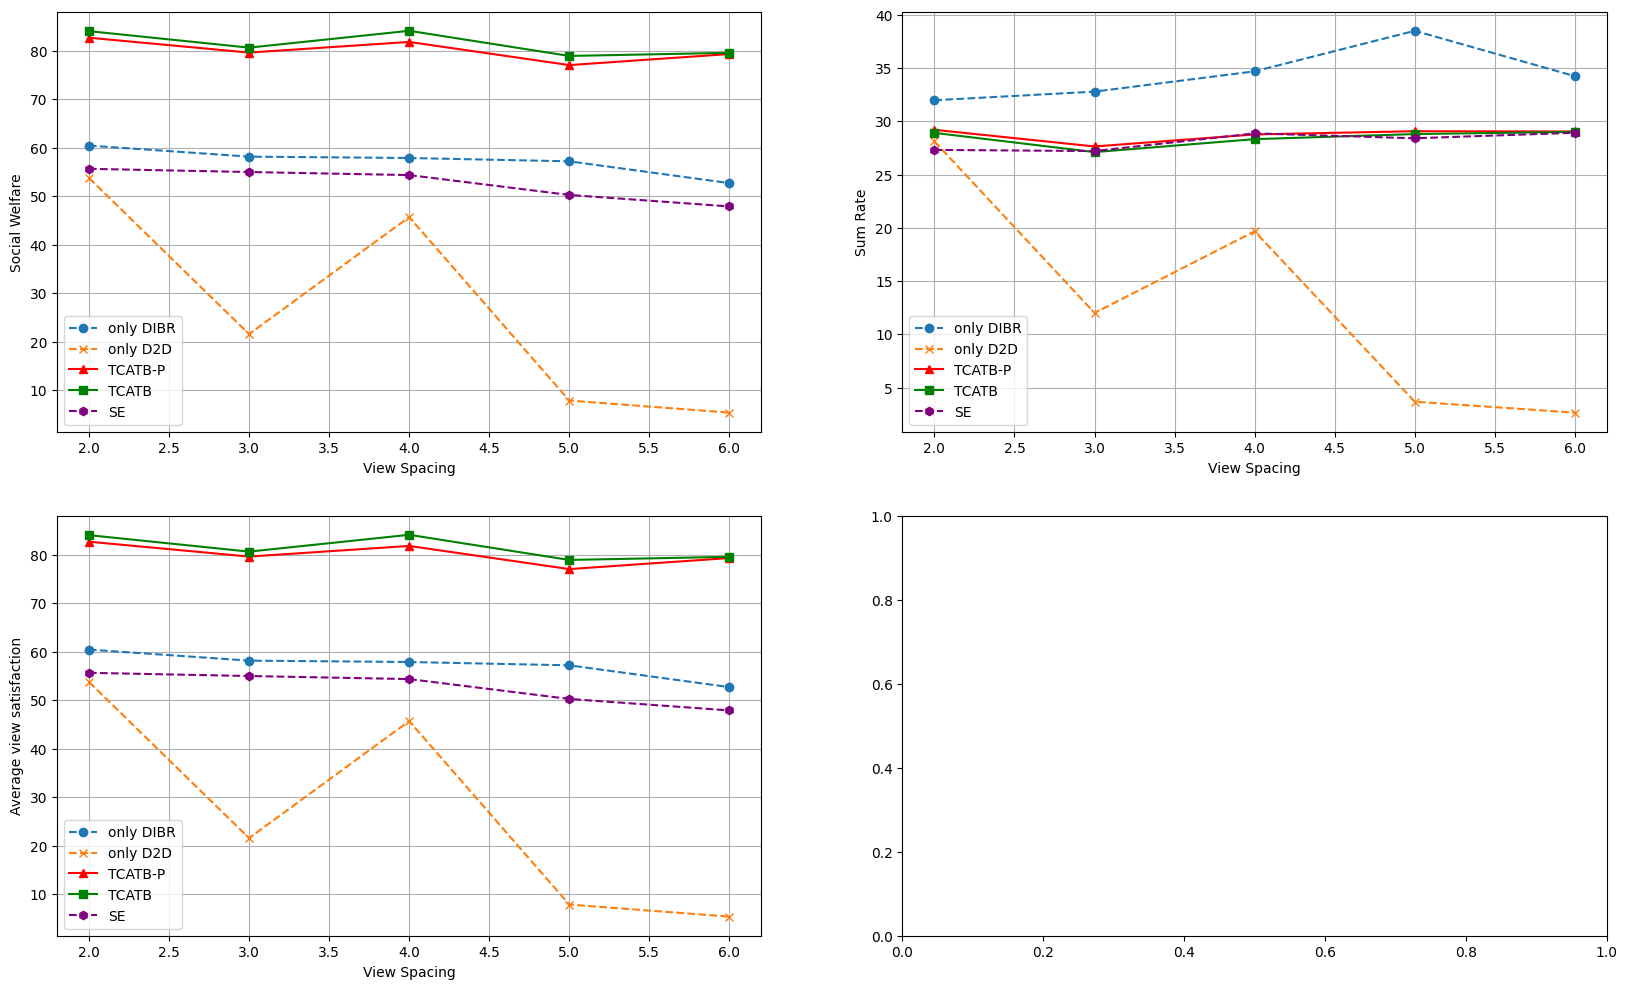

In [ ]:
# Default Parameters

V = 10
W = 2
num_viewers=30
num_d2d=10
grid_size=100
BS_capacity = 10
Delta_DIBR = 3
Dist_D2D = grid_size/3

#Transmission
P_B = 30
P_d = 23
N_0 = 9

# Number of viewers vs Social Welfare
exp_W = [2, 3, 4, 5, 6]
size = len(exp_W)

only_DIBR_s, only_d2d_s, tcatb_p_s, tcatb_s, s_s = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_dr, only_d2d_dr, tcatb_p_dr, tcatb_dr, s_dr = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size
only_DIBR_vs, only_d2d_vs, tcatb_p_vs, tcatb_vs, s_vs = [0]*size, [0]*size, [0]*size, [0]*size, [0]*size

round = 10

for i in range(round):
  for u in range(size):
    n = exp_W[u]
    U, bs = initiateBS(V, n, grid_size, BS_capacity)
    print(U)  # Print output to console
    Viewers = initiateViewer(0, V, n, num_viewers, num_d2d, grid_size)
    D2Ds = initiateD2D(0, V, n, num_d2d, grid_size)
    Transmitters = [bs] + D2Ds

    D_CE, D_D2D = MDMT(Viewers, Transmitters, Dist_D2D)
    D_CE_onlyD2D, D_D2D_onlyD2D = MDMT_onlyD2D(Viewers, Transmitters, Dist_D2D)

    LP_set = CDLC(D_CE, D_D2D, P_B, P_d, N_0)
    LP_set_onlyD2D = CDLC(D_CE_onlyD2D, D_D2D_onlyD2D, P_B, P_d, N_0)

    _,_,_, tcatb_p_u, tcatb_p_r, tcatb_p_v = TCATB_P(LP_set, BS_capacity, num_viewers)
    greedy_u, greedy_r, greedy_v = only_DIBR(LP_set, BS_capacity, num_viewers)
    tcatb_u, tcatb_r, tcatb_v = TCATB(LP_set, BS_capacity, Viewers, Transmitters)
    # only_D2D_u, only_D2D_r, only_D2D_v = TCATB(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    only_D2D_u, only_D2D_r, only_D2D_v = SE2(LP_set_onlyD2D, BS_capacity, Viewers, Transmitters)
    s_u, s_r, s_v = SE2(LP_set, BS_capacity, Viewers, Transmitters)

    print("Only-DIBR:", greedy_u)  # Print output to console
    print("Only-D2D:", only_D2D_u)  # Print output to console
    print("TCATB-P:", tcatb_p_u)  # Print output to console
    print("TCATB:", tcatb_u)  # Print output to console
    print("SE:", s_u)  # Print output to console

    only_DIBR_s[u] += (greedy_u)
    only_d2d_s[u] += (only_D2D_u)
    tcatb_p_s[u] += (tcatb_p_u)
    tcatb_s[u] += (tcatb_u)
    s_s[u] += (s_u)

    only_DIBR_dr[u] += (greedy_r)
    only_d2d_dr[u] += (only_D2D_r)
    tcatb_p_dr[u] += (tcatb_p_r)
    tcatb_dr[u] += (tcatb_r)
    s_dr[u] += (s_r)

    only_DIBR_vs[u] += (greedy_u)
    only_d2d_vs[u] += (only_D2D_u)
    tcatb_p_vs[u] += (tcatb_p_u)
    tcatb_vs[u] += (tcatb_u)
    s_vs[u] += (s_u)

for i in range(size):
  only_DIBR_s[i] /= round
  only_d2d_s[i] /= round
  tcatb_p_s[i] /= round
  tcatb_s[i] /= round
  s_s[i] /= round

  only_DIBR_dr[i] /= round
  only_d2d_dr[i] /= round
  tcatb_p_dr[i] /= round
  tcatb_dr[i] /= round
  s_dr[i] /= round

  only_DIBR_vs[i] /= round
  only_d2d_vs[i] /= round
  tcatb_p_vs[i] /= round
  tcatb_vs[i] /= round
  s_vs[i] /= round

print("X-axis:", exp_W)  # Print output to console
print("Social Welfare:")  # Print output to console
print("Only DIBR:", only_DIBR_s)  # Print output to console
print("Only D2D:", only_d2d_s)  # Print output to console
print("SE:", s_s)  # Print output to console
print("TCATB-P:", tcatb_p_s)  # Print output to console
print("TCATB:", tcatb_s)  # Print output to console

print("Sum Rate:")  # Print output to console
print("Only DIBR:", only_DIBR_dr)  # Print output to console
print("Only D2D:", only_d2d_dr)  # Print output to console
print("SE:", s_dr)  # Print output to console
print("TCATB-P:", tcatb_p_dr)  # Print output to console
print("TCATB:", tcatb_dr)  # Print output to console

print("Average view satisfaction:")  # Print output to console
print("Only DIBR:", only_DIBR_vs)  # Print output to console
print("Only D2D:", only_d2d_vs)  # Print output to console
print("SE:", s_vs)  # Print output to console
print("TCATB-P:", tcatb_p_vs)  # Print output to console
print("TCATB:", tcatb_vs)  # Print output to console

fig, axs = plt.subplots(2, 2, figsize=(20, 12)) # Adjusting the figsize to accommodate both plots

# First plot on the left
axs[0,0].plot(exp_W, only_DIBR_s, label='only DIBR', linestyle='dashed', marker='o')
axs[0,0].plot(exp_W, only_d2d_s, label='only D2D', linestyle='dashed', marker='x')
axs[0,0].plot(exp_W, tcatb_p_s, label='TCATB-P', marker='^', color='red')
axs[0,0].plot(exp_W, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_W, s_s, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('View Spacing')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_W, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_W, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_W, tcatb_p_dr, label='TCATB-P', marker='^', color='red')
axs[0,1].plot(exp_W, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_W, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('View Spacing')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_W, only_DIBR_vs, label='only DIBR', linestyle='dashed', marker='o')
axs[1,0].plot(exp_W, only_d2d_vs, label='only D2D', linestyle='dashed', marker='x')
axs[1,0].plot(exp_W, tcatb_p_vs, label='TCATB-P', marker='^', color='red')
axs[1,0].plot(exp_W, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_W, s_vs, label='SE', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('View Spacing')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

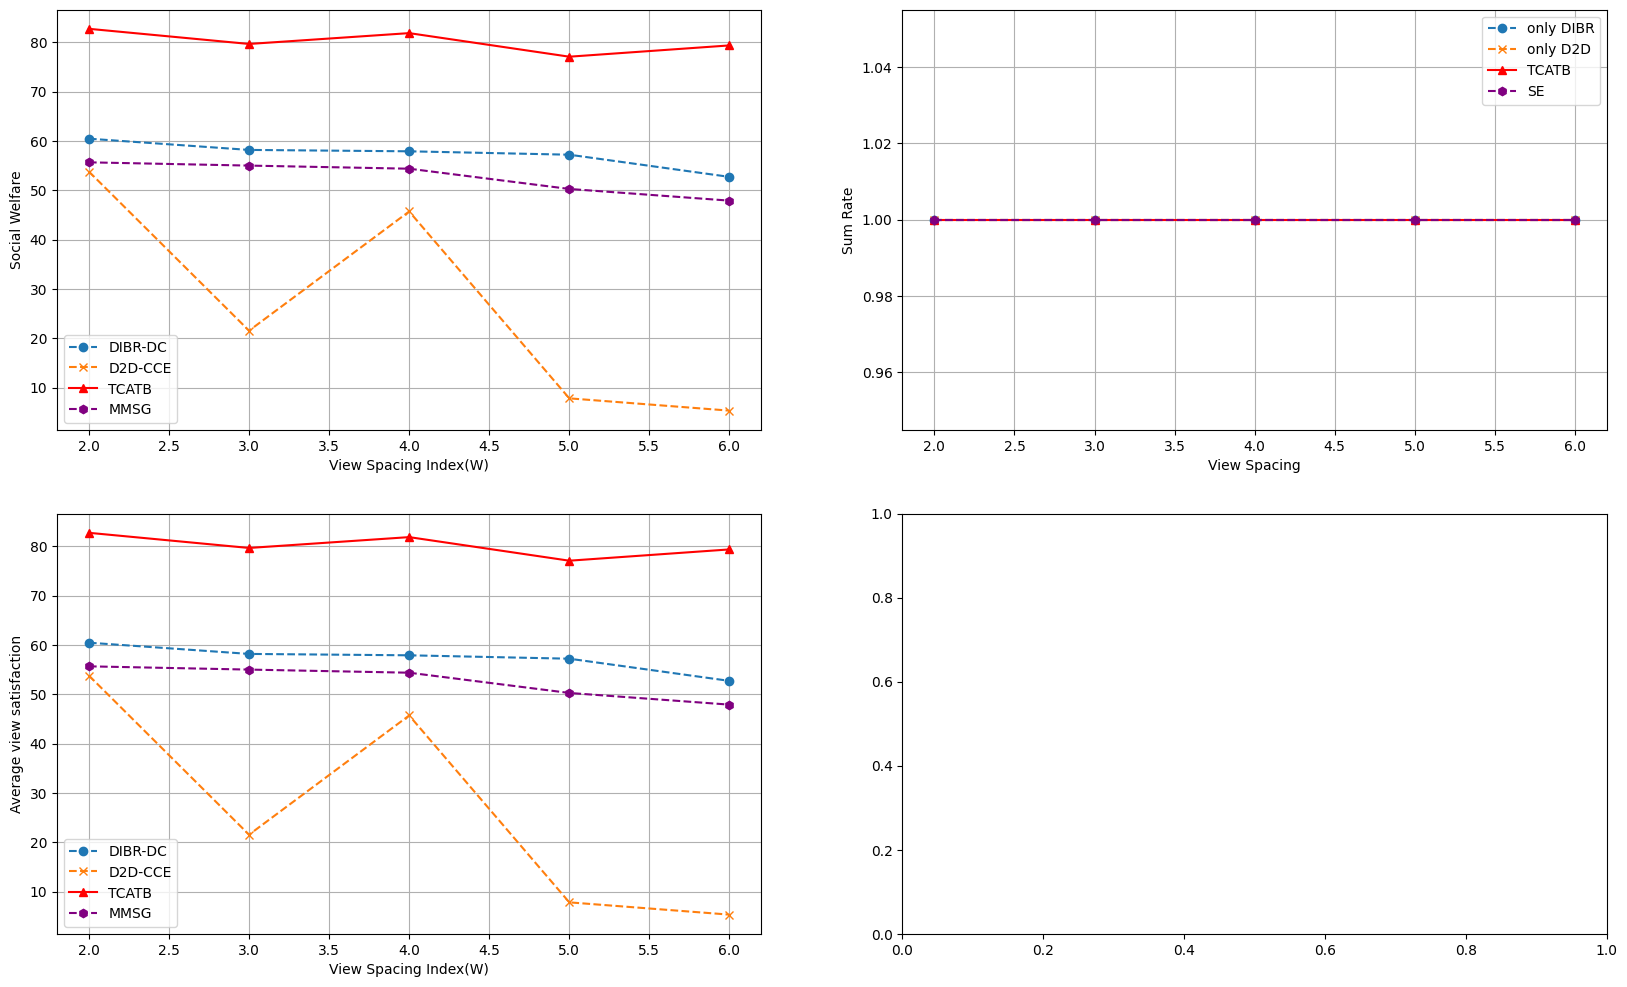

In [19]:
exp_W = [2, 3, 4, 5, 6]

only_DIBR_s = [60.44232067979376, 58.16713365422244, 57.886395034134885, 57.19818197988802, 52.70466155739224]
only_d2d_s = [53.77714660951625, 21.548889337765836, 45.69795806939108, 7.838180947763638, 5.3498768171238735]
s_s = [55.65186645699864, 54.99221316210473, 54.36107796952522, 50.25988325459107, 47.89192913016216]
tcatb_p_s = [82.70205924108907, 79.63361387500751, 81.82945234996347, 77.05265419579196, 79.33821088355656]
tcatb_s = [84.05594065734233, 80.65555266891468, 84.12453437008828, 78.93931708100342, 79.58687272822458]

only_DIBR_dr = [1]*5
only_d2d_dr = [1]*5
tcatb_p_dr = [1]*5
tcatb_dr = [1]*5
s_dr = [1]*5

only_DIBR_vs = [60.44232067979376, 58.16713365422244, 57.886395034134885, 57.19818197988802, 52.70466155739224]
only_d2d_vs = [53.77714660951625, 21.548889337765836, 45.69795806939108, 7.838180947763638, 5.3498768171238735]
s_vs = [55.65186645699864, 54.99221316210473, 54.36107796952522, 50.25988325459107, 47.89192913016216]
tcatb_p_vs = [82.70205924108907, 79.63361387500751, 81.82945234996347, 77.05265419579196, 79.33821088355656]
tcatb_vs = [84.05594065734233, 80.65555266891468, 84.12453437008828, 78.93931708100342, 79.58687272822458]

fig, axs = plt.subplots(2, 2, figsize=(20, 12)) # Adjusting the figsize to accommodate both plots

# First plot on the left
axs[0,0].plot(exp_W, only_DIBR_s, label='DIBR-DC', linestyle='dashed', marker='o')
axs[0,0].plot(exp_W, only_d2d_s, label='D2D-CCE', linestyle='dashed', marker='x')
axs[0,0].plot(exp_W, tcatb_p_s, label='TCATB', marker='^', color='red')
#axs[0,0].plot(exp_W, tcatb_s, label='TCATB', marker='s', color='green')
axs[0,0].plot(exp_W, s_s, label='MMSG', linestyle='dashed', marker='h', color='purple')
axs[0,0].set_xlabel('View Spacing Index(W)')
axs[0,0].set_ylabel('Social Welfare')
axs[0,0].legend()
axs[0,0].grid(True)

# Second plot on the right
axs[0,1].plot(exp_W, only_DIBR_dr, label='only DIBR', linestyle='dashed', marker='o')
axs[0,1].plot(exp_W, only_d2d_dr, label='only D2D', linestyle='dashed', marker='x')
axs[0,1].plot(exp_W, tcatb_p_dr, label='TCATB', marker='^', color='red')
#axs[0,1].plot(exp_W, tcatb_dr, label='TCATB', marker='s', color='green')
axs[0,1].plot(exp_W, s_dr, label='SE', linestyle='dashed', marker='h', color='purple')
axs[0,1].set_xlabel('View Spacing')
axs[0,1].set_ylabel('Sum Rate')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].plot(exp_W, tcatb_p_vs, label='TCATB', marker='^', color='red')
axs[1,0].plot(exp_W, only_DIBR_vs, label='DIBR-DC', linestyle='dashed', marker='o')
axs[1,0].plot(exp_W, only_d2d_vs, label='D2D-CCE', linestyle='dashed', marker='x')
#axs[1,0].plot(exp_W, tcatb_vs, label='TCATB', marker='s', color='green')
axs[1,0].plot(exp_W, s_vs, label='MMSG', linestyle='dashed', marker='h', color='purple')
axs[1,0].set_xlabel('View Spacing Index(W)')
axs[1,0].set_ylabel('Average view satisfaction')
axs[1,0].legend()
axs[1,0].grid(True)

In [ ]:
with open('ViewSpacing.csv', 'w', newline='') as csvfile:

  # 以空白分隔欄位，建立 CSV 檔寫入器
  writer = csv.writer(csvfile, delimiter=',')

  writer.writerow(["X-axis"]+exp_W)
  writer.writerow(["Social Welfare"])
  writer.writerow(['Only DIBR']+only_DIBR_s)
  writer.writerow(['Only D2D']+only_d2d_s)
  writer.writerow(['SE']+s_s)
  writer.writerow(['TCATB-P']+tcatb_p_s)
  writer.writerow(['TCATB']+tcatb_s)
  writer.writerow(["Sum Rate"])
  writer.writerow(['Only DIBR']+only_DIBR_dr)
  writer.writerow(['Only D2D']+only_d2d_dr)
  writer.writerow(['SE']+s_dr)
  writer.writerow(['TCATB-P']+tcatb_p_dr)
  writer.writerow(['TCATB']+tcatb_dr)
  writer.writerow(["Average view satisfaction"])
  writer.writerow(['Only DIBR']+only_DIBR_vs)
  writer.writerow(['Only D2D']+only_d2d_vs)
  writer.writerow(['SE']+s_vs)
  writer.writerow(['TCATB-P']+tcatb_p_vs)
  writer.writerow(['TCATB']+tcatb_vs)